In [1]:
import numpy as np
from astropy import constants as const
from astropy import units as u
from astropy.io import fits
from reproject import reproject_interp
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import aplpy
import pandas as pd
import math
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from astropy.table import Table
import matplotlib.gridspec as gridspec
from deproject import deproject
import seaborn as sns
from astropy.coordinates import SkyCoord
import Metallicity 
import alphaCO 

This Code is modeling the Ram Pressure and Restoring Pressure for 10 to 50 galaxies from the PHANGS and VERTICO sample.
Assumptions: 
- Surface density = sigma *cos(incl) (Error = e_sigma * cos(incl)
- Stellar maps: <= 0 to nans
- convertion factor metallicity dependent - radial metallicity gradient
- All galaxies at 16.5 Mpc distance



This Part of the Code takes care of the files and accessing the data

In [2]:
v_M87 = 1284.011278 * u.km/u.s # helio_velocity (from NED) from M87
dv_M87 = 5.096472*u.km/u.s
d_sun_M87 = 16.5 *u.Mpc #(VERTICO Team assumes that)
r_virgo = 1550*u.kpc #McLaughlin 1999; Ferrarese et al. 2012
v_disp_virgo = 593 *u.km/u.s #(Mei et al. 2007)
color_lst = color_list = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
    '#bcbd22', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94',
    '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5', '#393b79', '#637939', '#8c6d31', '#843c39',
    '#5254a3', '#6b6ecf', '#637939', '#8c6d31', '#843c39', '#5254a3', '#6b6ecf', '#8ca252',
    '#bd9e39', '#ad494a', '#756bb1', '#9c9ede', '#756bb1', '#9c9ede', '#a55194', '#ce6dbd',
    '#de9ed6', '#3182bd', '#e6550d', '#636363', '#969696', '#636363', '#969696', '#9e9ac8',
    '#cbc9e2', '#756bb1', '#9c9ede', '#756bb1', '#9c9ede'
]

#['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','lightblue','yellow']


loc = '/home/greisc1/'
incl_cut = 75
position_file =loc+ 'Project/Data/VERTICO_coord.fits'  #('Galaxy', 'S7'), ('RA', '>f4'), ('DEC', '>f4'), ('v_opt', '>f8'), ('inclination', '>f8'), ('pa', '>f8')
VERTICO_table = Table.read(position_file, format='fits')
galaxies = VERTICO_table['Galaxy']
PHANGS_table = Table.read(loc + 'Project/Data/phangs_sample_table_v1p6.fits', format ='fits')
PHANGS_galaxies = PHANGS_table['name']
Zabel_table = pd.read_csv(loc+ 'Project/Data/zabel22_table1.csv', sep=',')



def FOV(hdr):
    '''Takes the header of a fits file and calculates the radius of the image
    returns width, height and r in deg'''
    
    NAXIS1 = hdr['NAXIS1']
    NAXIS2 = hdr['NAXIS2']
    CDELT1 = hdr['CDELT1']
    CDELT2 = hdr['CDELT2']
    width = NAXIS1*CDELT1
    height = NAXIS2*CDELT2
    if width > height:
        r = width/2
        
    else:
        r = height/2

    return width, height, r 


def basic_plot(axis_number, scalebar_length,ra,dec,hdr):
    '''Function adds a colorbar, removes axis and tick_labels and ticks, adds a scalebar, and recenters the image
    
    Add this line after f.show_colorscale() and before f.colorbar.show()
    axis number = f1 or f2..., scalebar_length = flot or integer (number in kpc), ra,dec in deg
   '''
    
    axis_number.add_colorbar()
    width, height,r = FOV(hdr)
    axis_number.axis_labels.hide()
    axis_number.tick_labels.hide()
    axis_number.ticks.hide()
    axis_number.add_scalebar(length=np.rad2deg((u.rad*scalebar_length*u.kpc/(16.5*u.Mpc)).to('deg')))
    axis_number.scalebar.set_color('k')
    #axis_number.scalebar.set_corner('bottom left')
    axis_number.scalebar.set_label(f"{scalebar_length} kpc")
    axis_number.scalebar.set_font_size("small")
    #axis_number.recenter(ra, dec, radius= r)

def PHANGS_data(galaxy):
    '''Returns ra, dec, incl, posang and r_eff, r_25 in deg'''
    
    table = Table.read(loc + 'Project/Data/phangs_sample_table_v1p6.fits', format ='fits')
    idx = np.where(table['name']==f'ngc{galaxy[-4:]}')
    ra = np.array(table['orient_ra'])[idx] 
    dec = np.array(table['orient_dec'])[idx] 
    incl = np.array(table['orient_incl'])[idx]   
    posang = np.array(table['orient_posang'])[idx] 
    r_eff = np.array(table['size_reff'])[idx] 
    r_25 = np.array(table['size_r25'])[idx] 


    return ra,dec,incl,posang,r_eff,r_25

def VERTICO_data(galaxy):
    '''v_M87 (in km/s) and d_sun_M87 (in Mpc) have to be defined before in the file
    Returns ra, dec, incl, posang  in deg, v_gal (radial) and projected ditance d_proj in kpc'''
    
    props = pd.read_csv(loc + 'Project/Data/VERTICO_prop_Nov22.txt', sep=',')
    idx_prop = np.where(props['Galaxy']==f'NGC{galaxy[-4:]}')
    v_gal = (np.array(props['v_opt'])[idx_prop]-v_M87.value)*u.km/u.s  #relative velocity galaxy to M87
    dM87 = np.array(props['dM87'])[idx_prop]   #projected distance in degree
    d_proj = (np.deg2rad(dM87)*d_sun_M87).to('kpc')    #projected distance to M87 in Mpc

  
    table = Table.read(loc+ 'Project/Data/VERTICO_coord.fits', format='fits')
    idx = np.where(table['Galaxy']==f'NGC{galaxy[-4:]}')
    ra = np.array(table['RA'])[idx] 
    dec = np.array(table['DEC'])[idx] 
    incl = np.array(table['inclination'])[idx]   
    posang = np.array(table['pa'])[idx] 
    
    return ra,dec,incl,posang,v_gal,d_proj


def Zabel_table1(galaxy):
    '''Returns a dictonary containing table 1 of Zabel et al 2022 
    contains: HI_class (0,I,II..),HI_def_M,HI_def_R, H2_def  and stellar radius R* '''
    table = pd.read_csv(loc+ 'Project/Data/zabel22_table1.csv', sep=',')

    for position, Zab_galaxy in enumerate(table['Galaxy']):
        if Zab_galaxy == f'NGC{galaxy[-4:]}' or Zab_galaxy == f'NGC{galaxy[-4:]} (a)':
            
            Zabel_dict = {
                'Galaxy': table['Galaxy'][position],
                'HI_class': table['cl'][position],
                'HI_def_M': table['def_HI;M* (dex)'][position],
                'HI_def_R': table['def_HI;R* (dex)'][position],
                'H2_def': table['def_H2 (dex)'][position],
                'R_star': table['R* (kpc)'][position],
                'logM': table['log M* (Msol)'][position]
            }

    return Zabel_dict


def VERTICOIV_table1(galaxy):
    '''Returns a dictonary containing table 1 of Villanueva et al 2023 (VERTICOIV) 
    contains: M_mol, M_star, lmol, l*(exponential scale length), Re,mol, Re,* (half-light radius, effective radius)  '''
    table = pd.read_csv(loc+ 'Project/Data/VERTICOIV.txt', sep=',')

    
    for i, VERTICOIV_galaxy in enumerate(table['Name']):
        if VERTICOIV_galaxy == f'NGC{galaxy[-4:]}' or VERTICOIV_galaxy == f'NGC{galaxy[-4:]} (a)':
    
            VERTICOIV_dict = {
                'Galaxy': table['Name'][i],
                'HI_class': table['HI-Class'][i],
                'logMmol': float(table['logMmol'][i][3:7]),
                'logM*': float(table['logM*'][i][3:8]),
                'l_mol': float(table['l_mol(kpc)'][i][3:7]),
                'l_*': float(table['l_*(kpc)'][i][3:7]),
                'R_e_mol': float(table['R_e_mol(kpc)'][i][3:7]),
                'R_e_*': float(table['R_e_*(kpc)'][i][3:7])
            }

    return VERTICOIV_dict

    
def convert_co_mass(L_co): 
    '''convert mol data from CO linewidth to gas mass
    returns M_mol in units of M_sol/pc^2'''
    
    alpha_co =4.35 * u.Msun / u.pc **2
    R_21=0.8
    M_mol = alpha_co/R_21*L_co
    
    return M_mol

def Convert_CO_Mass_Radial(galaxy, L_co, ra,dec, incl, posang, hdr_mol):
    '''convert mol data from CO linewidth to gas mass
    returns M_mol in units of M_sol/pc^2 using metallicity dependent convertion factor
    Predict 12+log(O/H) with the 'SAMI19' MZR (Sanchez+19), 
    alphaCO10 with a simple power-law metallicity dependence (Sun+ 2020)'''

    R_array,_ = deproject((ra*u.deg,dec*u.deg),incl*u.deg, posang*u.deg, header=hdr_mol)
    R_array= np.deg2rad(np.array(R_array))*d_sun_M87.to('kpc')
    VERTICOIV_dict = VERTICOIV_table1(galaxy)
    M_star = 10**(VERTICOIV_dict['logM*'])*u.M_sun
    R_e = VERTICOIV_dict['R_e_*']*u.kpc
    logOH_R_e = Metallicity.predict_logOH_SAMI19(M_star)
    logOH_galaxy = Metallicity.extrapolate_logOH_radially(logOH_R_e, gradient='CALIFA14', Rgal=R_array, Re=R_e)
    Zprime = 10**(logOH_galaxy-8.7) #convert to ratio metals compared to solar metallicity #asplund+ 2009 (anual review)
    alphaCO_galaxy = alphaCO.predict_alphaCO10_S20(Zprime)

    R_21=0.8
    M_mol = alphaCO_galaxy/R_21*L_co
    #print(f'Mstar {M_star} R_e {R_e},  R_array {R_array }logOH_galaxy, {logOH_galaxy} alphaCO {alphaCO_galaxy}')

    
    return M_mol

def Mol_Gas_file(galaxy,resolution):
    '''returns mol gas file for specific resolution and galaxy. 
    Here is all the mol gas data one uses in the project'''
    
    if resolution == 'VERTICO_9as':
        Mol_gas_file = f"{loc}VERTICO/Mol_gas/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
    elif resolution == 'VERTICO_9as_e':
        Mol_gas_file = f"{loc}VERTICO/Mol_gas/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"
    elif resolution == 'PHANGS_high':
        Mol_gas_file = f"{loc}PHANGS/ngc{galaxy[-4:]}/ngc{galaxy[-4:]}_12m+7m+tp_co21_broad_mom0.fits"
    elif resolution == 'PHANGS_high_e':
        Mol_gas_file = f"{loc}PHANGS/ngc{galaxy[-4:]}/ngc{galaxy[-4:]}_12m+7m+tp_co21_broad_emom0.fits"
    elif resolution == 'PHANGS_high_strict':
        Mol_gas_file = f"{loc}PHANGS/ngc{galaxy[-4:]}/ngc{galaxy[-4:]}_12m+7m+tp_co21_strict_mom0.fits"
    elif resolution == 'PHANGS_high_strict_e':
        Mol_gas_file = f"{loc}PHANGS/ngc{galaxy[-4:]}/ngc{galaxy[-4:]}_12m+7m+tp_co21_strict_emom0.fits"
    elif resolution == 'PHANGS_7.5as':
        Mol_gas_file = f"{loc}PHANGS/ngc{galaxy[-4:]}/ngc{galaxy[-4:]}_12m+7m+tp_co21_7p5as_broad_mom0.fits"
    elif resolution == 'PHANGS_7.5as_e':
        Mol_gas_file = f"{loc}PHANGS/ngc{galaxy[-4:]}/ngc{galaxy[-4:]}_12m+7m+tp_co21_7p5as_broad_emom0.fits"
    
    else:
        Mol_gas_file = f"{loc}VERTICO/Mol_gas/{galaxy}/not_here_file.fits"

    
    return Mol_gas_file


def data_maps(galaxy, resolution, ra, dec, incl, posang):
    '''NO UNITS
    for a specific galaxy with molecular gas of spedific resolution the funcion 
    returns the molecular gas and stellar mass surface density and hdr_mol 
    corrected for the inclination of the galaxy (surface density is smaller than observed one cos(incl))
    !stellar maps: <= 0 to nans -> !'''
    
    mol_map_path = Mol_Gas_file(galaxy, resolution)
        
    # Mol mass maps
    hdul_mol = fits.open(mol_map_path)
    hdr_mol = hdul_mol[0].header
    data_mol = hdul_mol[0].data
    #sigma_mol = convert_co_mass(data_mol)  #constant converstion CO line to H2
    sigma_mol = Convert_CO_Mass_Radial(galaxy, data_mol, ra,dec, incl, posang, hdr_mol)
    # Stellar mass maps
    stellar_maps = f"{loc}sfr_mstar_maps/15as_new/{galaxy}_mstar_w1+w3_15as.fits"
    hdul_s = fits.open(stellar_maps)
    hdr_s = hdul_s[0].header
    data_s = hdul_s[0].data
    
    # Replace 0 with NaN
    data_s = np.where(data_s <= 0,np.nan,data_s)
    
    # make same grid as Vertico mol data
    sigma_s, _ = reproject_interp((data_s,hdr_s), hdr_mol)


    #inlination effect
    sigma_s = sigma_s*np.cos(np.deg2rad(incl))
    sigma_mol =sigma_mol*np.cos(np.deg2rad(incl))
    tot_mol = np.nansum(np.nansum(sigma_mol))

    
    return sigma_s, sigma_mol.value, hdr_mol, tot_mol.value


def e_data_maps(galaxy, resolution, ra, dec, incl, posang):
    '''returns e_mol maps for specific galaxy and resolution. Corrected for inclination?'''
    
    mol_map_path = Mol_Gas_file(galaxy, f'{resolution}_e')  
    # Mol mass maps
    hdul_mol = fits.open(mol_map_path)
    hdr_mol = hdul_mol[0].header
    e_data_mol = hdul_mol[0].data

    #e_sigma_mol = convert_co_mass(e_data_mol) #constant alpha_CO
    e_sigma_mol = Convert_CO_Mass_Radial(galaxy, e_data_mol, ra,dec, incl, posang, hdr_mol) #metallicity alphaCO
    e_sigma_mol =e_sigma_mol*np.cos(np.deg2rad(incl))
    
    return e_sigma_mol.value


def sigma_mol_limits(sigma_mol,e_sigma_mol,Type):
    if Type == 'strict':
      sigma_mol = np.where((sigma_mol < 3*e_sigma_mol ),0, sigma_mol)
    elif Type == 'Upper limit':
      sigma_mol = np.where((sigma_mol < 3*e_sigma_mol ),e_sigma_mol , sigma_mol)
    elif Type == '3*Upper limit':
      sigma_mol = np.where((sigma_mol < 3*e_sigma_mol ),3*e_sigma_mol , sigma_mol)
    else:
        sigma_mol = 'error'
    return sigma_mol


def Susceptible_gas(div, sigma_mol, e_sigma_mol, P_s, P_RP,Type):
    sigma_max =np.divide(P_RP, np.divide(P_s,sigma_mol))
    if Type == 'Trust broad':
        susc_mol = np.where(div <= 1, sigma_mol,0)
    if Type == 'Lower limit':
        susc_mol = np.where(np.logical_or(div > 1, np.logical_and(sigma_mol < 3 * e_sigma_mol,sigma_mol+ e_sigma_mol > sigma_max)), 0, sigma_mol)
    if Type == 'Upper limit':
        susc_mol = np.where(np.logical_or(div <= 1, np.logical_and(sigma_mol < 3 * e_sigma_mol,sigma_mol- e_sigma_mol < sigma_max)), sigma_mol,0)
    if Type == 'Lower limit2':
        susc_mol = np.where(np.logical_or(div > 1, sigma_mol < 3* e_sigma_mol), 0, sigma_mol)
    if Type == 'Upper limit2':
        susc_mol = np.where(np.logical_or(div <= 1, sigma_mol < 3* e_sigma_mol), sigma_mol,0)
    if Type == 'Lower limit3':
        susc_mol = np.where(np.logical_or(div > 1, sigma_mol+ e_sigma_mol > sigma_max), 0, sigma_mol)
    if Type == 'Upper limit3':
        susc_mol = np.where(np.logical_or(div <= 1, sigma_mol- e_sigma_mol < sigma_max), sigma_mol,0)


    return susc_mol




'''This Part of the Code gives galaxies properties and calculates their RP and Restoring Pressure'''

def Pressure(sigma_s, sigma_mol, tot_mol, hdr, v_ICM,d_center,phi,e_sigma_mol, Type):
    '''Normal case we would v_ICM = sqrt(3) * v_rad * np.cos(np.deg2rad(phi))
    and d_center = d_proj *np.pi/2
    
    Returns Restoring and Ram pressure in N/m^2 and rho_ICM in kg/m^3'''
     
    rho1=3.38*10**(-25)*u.g/u.cm**3
    rho2=1.175*10**(-26)*u.g/u.cm**3
    r1 = 1.7*u.kpc
    r2=21.4*u.kpc
    beta1 =0.42
    beta2=0.47
    
    rho_ICM= (rho1*(1+(d_center/r1)**2)**(-3*beta1/2)+rho2*(1+(d_center/r2)**2)**(-3*beta2/2)).to(u.kg/u.m**3)
    P_RP =(rho_ICM*(v_ICM*np.cos(np.deg2rad(phi)))**2).to(u.N/u.m**2) 

    '''Restoring Pressure'''    
    g_s = (2*const.G*sigma_s*u.solMass/u.pc**2*np.pi).to(u.m/u.s**2)  #restoring force stellar mass
    P_s = (g_s*sigma_mol*u.solMass/u.pc**2).to(u.N/u.m**2)
    
    '''Ratio of P_s and RP'''
    RP_arr = np.full_like(P_s, P_RP)   #array full of the RP value in size of restoring pressure
    div = np.divide(P_s, RP_arr)
    tot_mol = np.nansum(np.nansum(sigma_mol))
    
    susc_mol_gas = Susceptible_gas(div, sigma_mol, e_sigma_mol, P_s, P_RP,Type)
    tot_susc_mol = np.nansum(np.nansum(susc_mol_gas))
    strip_perc = 100 * tot_susc_mol/tot_mol

    return P_s, P_RP, rho_ICM, div, strip_perc


def Edge_On_Pressure(galaxy,resolution, sigma_s, sigma_mol, tot_mol, hdr_mol, v_ICM, d_center, e_sigma_mol, Type):
    ''''''
    if resolution == 'PHANGS_high':
        ra,dec,incl,posang,r_eff,r_25 = PHANGS_data(galaxy)    
    else:
        ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
        
    #load rotation velocity, interfolate and calculate v_array (v for every pixel through deprojected radius)
    table = Table.read(f'/home/greisc1/Project/Data/rotation_curves/rotation_curves/{galaxy}_model_legendre.ecsv', format ='ascii.ecsv')
    v_rot = table['V_circ']
    r_rot = table['r_gal']

    v_rot[0] = 0
    r_rot= (r_rot.to('deg'))

    r_array,_ = deproject((ra*u.deg,dec*u.deg),incl*u.deg, posang*u.deg, header=hdr_mol)
    v_array = np.interp(r_array, r_rot.value,v_rot)

    v_array = (v_array*u.km/u.s).to(u.parsec/u.s)
    r_array= np.deg2rad(np.array(r_array))*d_sun_M87.to('pc')
    P_s = np.divide(np.multiply(sigma_mol*u.solMass/u.pc**2,v_array**2),r_array).to(u.N/u.m**2)    

    _, P_RP, rho_ICM, _, _ = Pressure(sigma_s, sigma_mol,tot_mol, hdr_mol, v_ICM, d_center,0, e_sigma_mol, Type)
    P_RP = np.full_like(P_s, P_RP)   #array full of the RP value in size of restoring pressure

    div = np.divide(P_s, P_RP)
    #tot_mol = np.nansum(np.nansum(sigma_mol)) 
    susc_mol = Susceptible_gas(div, sigma_mol, e_sigma_mol, P_s, P_RP,Type)
    tot_susc_mol = np.nansum(np.nansum(susc_mol))
    strip_perc = 100 * tot_susc_mol/tot_mol

    return P_s, P_RP, rho_ICM, div, strip_perc
    


NGC4064
NGC4189


/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


NGC4254
NGC4293


/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


NGC4294
NGC4298
NGC4299


/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64

NGC4351
NGC4380
NGC4383


/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


NGC4394
NGC4405
NGC4419


/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


NGC4424
NGC4450
NGC4457


/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


NGC4501
NGC4532


/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


NGC4535
NGC4536


/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


NGC4548
NGC4561
NGC4567


/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


NGC4568
NGC4569
NGC4579


/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


NGC4580
NGC4606
NGC4651


/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


NGC4654
NGC4694


/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


NGC4698
NGC4713


/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


NGC4772
NGC4808


/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/mnt/astro/astro/home/greis

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

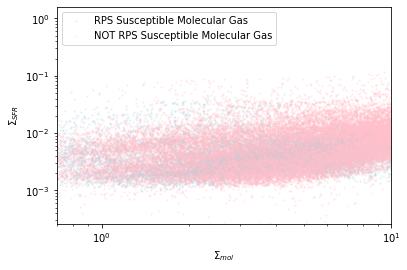

In [31]:
Type = 'Trust broad'  
resolution = 'VERTICO_9as'
phi = 0
plot_label = True
lower_bound = 0.7
upper_bound = 10
mol_lst = []
mol_susc_lst =[]
sfr_susc_lst =[]
sfr_lst = []
for i in range(len(galaxies)):
    galaxy = galaxies[i]
    ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
    if resolution == 'PHANGS_high':
        ra,dec,incl,posang,r_eff, r_25 = PHANGS_data(galaxy)


    if os.path.isfile(Mol_Gas_file(galaxy, resolution)) and os.path.isfile(f'/home/greisc1/VERTICO/SFR_VERTICO/NGC{galaxy[-4:]}_sfr_nuv+w3_9as.fits') and incl < incl_cut:
        print(galaxy)
        sigma_s, sigma_mol, hdr_mol, tot_mol = data_maps(galaxy, resolution, ra, dec, incl, posang)
        e_sigma_mol = e_data_maps(galaxy, resolution, ra, dec, incl, posang)          
        v_ICM = np.sqrt(3)*v_gal
        d_center = d_proj*np.pi/2


        hdul_s = fits.open(f'/home/greisc1/VERTICO/SFR_VERTICO/NGC{galaxy[-4:]}_sfr_nuv+w3_9as.fits')
        hdr_sfr = hdul_s[0].header
        data_sfr = hdul_s[0].data
            # make same grid as Vertico mol data
        data_sfr, _ = reproject_interp((data_sfr,hdr_sfr), hdr_mol)

        P_s, P_RP, rho_ICM, div, strip_perc = Pressure(sigma_s, sigma_mol, tot_mol, hdr_mol, v_ICM,d_center,phi,e_sigma_mol, Type)
        idx = (div <= 1)
        mol_susc = sigma_mol[idx]
        mol = sigma_mol[~idx]
        sfr_susc = data_sfr[idx]
        sfr = data_sfr[~idx]
        
        sfr_susc_lst.append(sfr_susc)
        sfr_lst.append(sfr)
        mol_susc_lst.append(mol_susc)
        mol_lst.append(mol)


        if plot_label:
            plt.scatter(mol_susc, sfr_susc, color='lightblue', s=2, alpha=0.2, label='RPS Susceptible Molecular Gas')
            plt.scatter(mol, sfr, color = 'pink', alpha = 0.2, s=2,label='NOT RPS Susceptible Molecular Gas')


            plot_label = False
        else:
            plt.scatter(mol_susc, sfr_susc, color='lightblue', s=2, alpha=0.2)
            plt.scatter(mol, sfr, color = 'pink', alpha = 0.2, s=2)
            
    
        plt.xlabel(r'$\Sigma_{mol}$') #missing units
        plt.ylabel(r'$\Sigma_{SFR}$') #missing units
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim(lower_bound,upper_bound)        
        plt.legend(loc='upper left')

sfr_lst = np.array(sfr_lst).flatten()       #plot best fits for region
sfr_susc_lst = np.array(sfr_susc_lst).flatten()       #plot best fits for region
mol_lst = np.array(mol_lst).flatten()       #plot best fits for region
mol_susc_lst = np.array(mol_susc_lst).flatten()


sfr_lst = np.where(mol_lst > lower_bound and mol_lst < upper_bound, sfr_lst, np.nan)
mol_lst = np.where(mol_lst > lower_bound and mol_lst < upper_bound, mol_lst, np.nan)
sfr_susc_lst = np.where(mol_susc_lst > lower_bound or mol_susc_lst < upper_bound, sfr_susc_lst, np.nan)
mol_susc_lst = np.where(mol_susc_lst > lower_bound or mol_susc_lst < upper_bound, mol_susc_lst, np.nan)

from scipy.optimize import curve_fit
def power_law(x, a, b):
    return a * np.power(x, b)

# Perform curve fitting
a_fit, b_fit, _ = curve_fit(power_law, mol_lst, sfr_lst)
# Perform curve fitting
a_susc_fit, b_susc_fit, _ = curve_fit(power_law, mol_susc_lst, sfr_susc_lst)

x= [lower_bound, upper_bound]
plt.plot(x, power_law(x, a_fit, b_fit), color='pink')

plt.plot(x, power_law(x, a_susc_fit, b_susc_fit), color='lightblue')



/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64

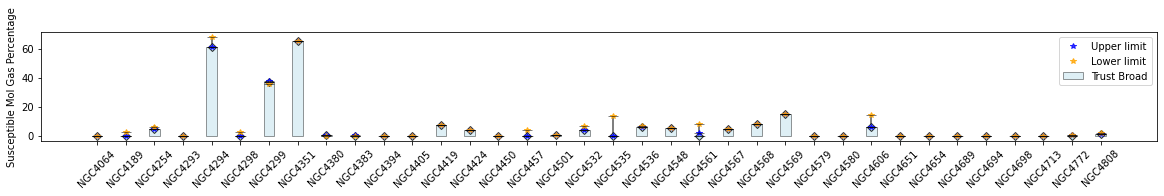

In [20]:
'''Plot all susceptible percentage of Mol Gas for PHANGS or VERTICO galaxies 
with their statistical upper and lower limit'''

phi= 0
resolution= 'VERTICO_9as'


susc_lst_trust = []
susc_lst_upper = []
susc_lst_lower = []
galaxy_lst=[]
PHANGS_galaxy_lst=[]

for i in range(len(galaxies)):
    galaxy = galaxies[i]
    ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
    if resolution == 'PHANGS_high':
        ra,dec,incl,posang,r_eff, r_25 = PHANGS_data(galaxy)


    if os.path.isfile(Mol_Gas_file(galaxy, resolution)) and incl < incl_cut:
        sigma_s, sigma_mol, hdr_mol, tot_mol = data_maps(galaxy, resolution, ra, dec, incl, posang)
        e_sigma_mol = e_data_maps(galaxy, resolution, ra, dec, incl, posang)
        
        v_ICM = np.sqrt(3)*v_gal
        d_center = d_proj*np.pi/2
        P_s, P_RP, rho_ICM, div, strip_perc_trust = Pressure(sigma_s, sigma_mol, tot_mol, hdr_mol, v_ICM, d_center,phi, e_sigma_mol, 'Trust broad')
        P_s, P_RP, rho_ICM, div, strip_perc_upper = Pressure(sigma_s, sigma_mol, tot_mol, hdr_mol, v_ICM, d_center,phi,e_sigma_mol, 'Upper limit')
        P_s, P_RP, rho_ICM, div, strip_perc_lower = Pressure(sigma_s, sigma_mol, tot_mol, hdr_mol, v_ICM, d_center,phi,e_sigma_mol, 'Lower limit')


        susc_lst_trust.append(strip_perc_trust)
        susc_lst_upper.append(strip_perc_upper)
        susc_lst_lower.append(strip_perc_lower)
        galaxy_lst.append(galaxy)
        
        if f'ngc{galaxy[-4:]}' in PHANGS_galaxies:
            PHANGS_galaxy_lst.append(galaxy)
            
            
upper_error=np.subtract(susc_lst_upper,susc_lst_trust)
lower_error=np.subtract(susc_lst_lower,susc_lst_trust)
pos_upper_errors = np.where(susc_lst_upper <susc_lst_trust,upper_error,0)
neg_upper_errors = np.where(susc_lst_upper > susc_lst_trust,upper_error,0)
pos_lower_errors = np.where(susc_lst_lower <susc_lst_trust,lower_error,0)
neg_lower_errors = np.where(susc_lst_lower > susc_lst_trust,lower_error,0)

# Create a bar plot
fig = plt.figure(figsize=(20, 2))
ax = fig.add_subplot(111)
x_values = np.arange(0, 4*len(galaxy_lst),4)
ax.bar(x_values, susc_lst_trust, color="lightblue", edgecolor ='k',alpha=0.4,width=1.5, label = 'Trust Broad')
ax.plot(x_values, susc_lst_trust, marker="D",markeredgecolor='k', linestyle="", alpha=0.8, color="lightblue")
ax.plot(x_values, susc_lst_upper, marker="*", linestyle="", alpha=0.8, color="blue",label = 'Upper limit')
ax.plot(x_values, susc_lst_lower, marker="*", linestyle="", alpha=0.8, color="orange", label = 'Lower limit')


#plt.errorbar(galaxy_lst, susc_lst_trust, yerr=, fmt='none', ecolor='black', capsize=5, elinewidth=2)
ax.errorbar(x_values, susc_lst_trust, yerr = (pos_upper_errors,neg_upper_errors), fmt='none', ecolor='k',alpha=0.5, capsize=5, elinewidth=2)
ax.errorbar(x_values, susc_lst_trust, yerr = (pos_lower_errors,neg_lower_errors), fmt='none', ecolor='k',alpha=0.5, capsize=5, elinewidth=2)



ax.set_xticks(x_values)
ax.set_xticklabels(galaxy_lst,rotation=45)
'''common_element = np.intersect1d(galaxy_lst, PHANGS_galaxy_lst)
index = np.where(np.isin(galaxy_lst, common_element))[0]
print(index)
ax.set_xticks(x_values[index])
ax.set_xticklabels(galaxy_lst[index],rotation=45, color = 'blue')'''

ax.set_ylabel('Susceptible Mol Gas Percentage')

plt.legend()
#plt.title(r'$\Sigma_{mol}< 3* e\Sigma_{mol}$ all susceptible or resistent')
plt.show()
plt.close()




/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64

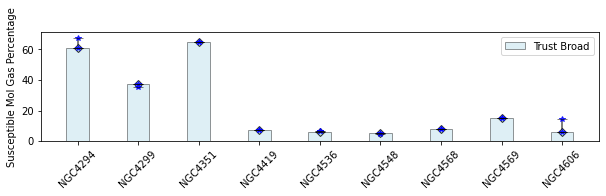

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64

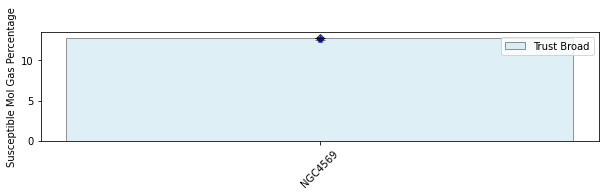

In [21]:
'''Plot all susceptible percentage of Mol Gas for PHANGS or VERTICO galaxies 
with their statistical upper and lower limit
ONLY Galaxies with more than certain Percentage'''


phi= 0
resolution= 'VERTICO_9as'
percentage_limit = 5

susc_lst_trust = []
susc_lst_upper = []
susc_lst_lower = []


galaxy_lst=[]

for i in range(len(galaxies)):
    galaxy = galaxies[i]
    ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
    if resolution == 'PHANGS_high':
        ra,dec,incl,posang,r_eff, r_25 = PHANGS_data(galaxy)


    if os.path.isfile(Mol_Gas_file(galaxy, resolution)) and incl < incl_cut:
        sigma_s, sigma_mol, hdr_mol, tot_mol = data_maps(galaxy, resolution, ra, dec, incl, posang)
        e_sigma_mol = e_data_maps(galaxy, resolution, ra, dec, incl, posang)
        
        v_ICM = np.sqrt(3)*v_gal
        d_center = d_proj*np.pi/2
        P_s, P_RP, rho_ICM, div, strip_perc_trust = Pressure(sigma_s, sigma_mol, tot_mol, hdr_mol, v_ICM, d_center,phi, e_sigma_mol, 'Trust broad')
        P_s, P_RP, rho_ICM, div, strip_perc_upper = Pressure(sigma_s, sigma_mol, tot_mol, hdr_mol, v_ICM, d_center,phi,e_sigma_mol, 'Upper limit')
        P_s, P_RP, rho_ICM, div, strip_perc_lower = Pressure(sigma_s, sigma_mol, tot_mol, hdr_mol, v_ICM, d_center,phi,e_sigma_mol, 'Lower limit')

        if strip_perc_trust > percentage_limit:
            susc_lst_trust.append(strip_perc_trust)
            susc_lst_upper.append(strip_perc_upper)
            susc_lst_lower.append(strip_perc_lower)
            galaxy_lst.append(galaxy)
            
        else:
            continue

        
upper_error=np.subtract(susc_lst_upper,susc_lst_trust)
lower_error=np.subtract(susc_lst_lower,susc_lst_trust)
pos_upper_errors = np.where(susc_lst_upper <susc_lst_trust,upper_error,0)
neg_upper_errors = np.where(susc_lst_upper > susc_lst_trust,upper_error,0)
pos_lower_errors = np.where(susc_lst_lower <susc_lst_trust,lower_error,0)
neg_lower_errors = np.where(susc_lst_lower > susc_lst_trust,lower_error,0)

# Create a Bar plot
fig = plt.figure(figsize=(10, 2))
ax = fig.add_subplot(111)
x_values = np.arange(0, 4*len(galaxy_lst),4)
ax.bar(x_values, susc_lst_trust, color="lightblue", edgecolor ='k',alpha=0.4,width=1.5, label = 'Trust Broad')
ax.plot(x_values, susc_lst_trust, marker="D",markeredgecolor='k', linestyle="", alpha=0.8, color="lightblue")
ax.plot(x_values, susc_lst_upper, marker="*", linestyle="", alpha=0.8, color="blue")
ax.plot(x_values, susc_lst_lower, marker="*", linestyle="", alpha=0.8, color="blue")


#plt.errorbar(galaxy_lst, susc_lst_trust, yerr=, fmt='none', ecolor='black', capsize=5, elinewidth=2)
ax.errorbar(x_values, susc_lst_trust, yerr= (pos_upper_errors,neg_upper_errors), fmt='none', ecolor='k',alpha=0.5, capsize=5, elinewidth=2)
ax.errorbar(x_values, susc_lst_trust, yerr= (pos_lower_errors,neg_lower_errors), fmt='none', ecolor='k',alpha=0.5, capsize=5, elinewidth=2)
ax.set_xticks(x_values)
ax.set_xticklabels(galaxy_lst,rotation=45)
ax.set_ylabel('Susceptible Mol Gas Percentage')
plt.legend()
plt.show()
plt.close()

resolution= 'PHANGS_high'
susc_lst_trust = []
susc_lst_upper = []
susc_lst_lower = []
galaxy_lst=[]

for i in range(len(galaxies)):
    galaxy = galaxies[i]
    ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
    if resolution == 'PHANGS_high':
        ra,dec,incl,posang,r_eff, r_25 = PHANGS_data(galaxy)


    if os.path.isfile(Mol_Gas_file(galaxy, resolution)) and incl < incl_cut:
        sigma_s, sigma_mol, hdr_mol, tot_mol = data_maps(galaxy, resolution, ra, dec, incl, posang)
        e_sigma_mol = e_data_maps(galaxy, resolution, ra, dec, incl, posang)
        
        v_ICM = np.sqrt(3)*v_gal
        d_center = d_proj*np.pi/2
        P_s, P_RP, rho_ICM, div, strip_perc_trust = Pressure(sigma_s, sigma_mol, tot_mol, hdr_mol, v_ICM, d_center,phi, e_sigma_mol, 'Trust broad')
        P_s, P_RP, rho_ICM, div, strip_perc_upper = Pressure(sigma_s, sigma_mol, tot_mol, hdr_mol, v_ICM, d_center,phi,e_sigma_mol, 'Upper limit')
        P_s, P_RP, rho_ICM, div, strip_perc_lower = Pressure(sigma_s, sigma_mol, tot_mol, hdr_mol, v_ICM, d_center,phi,e_sigma_mol, 'Lower limit')

        if strip_perc_trust > percentage_limit:
            susc_lst_trust.append(strip_perc_trust)
            susc_lst_upper.append(strip_perc_upper)
            susc_lst_lower.append(strip_perc_lower)
            galaxy_lst.append(galaxy)
            
        else:
            continue

        
x_values = np.arange(0, 4*len(galaxy_lst),4)
upper_error=np.subtract(susc_lst_upper,susc_lst_trust)
lower_error=np.subtract(susc_lst_lower,susc_lst_trust)
pos_upper_errors = np.where(susc_lst_upper <susc_lst_trust,upper_error,0)
neg_upper_errors = np.where(susc_lst_upper > susc_lst_trust,upper_error,0)
pos_lower_errors = np.where(susc_lst_lower >susc_lst_trust,lower_error,0)
neg_lower_errors = np.where(susc_lst_lower < susc_lst_trust,lower_error,0)

# Create a bar plot
fig = plt.figure(figsize=(10, 2))
ax = fig.add_subplot(111)
ax.bar(x_values, susc_lst_trust, color="lightblue", edgecolor ='k',alpha=0.4,width=1.5, label = 'Trust Broad')
ax.plot(x_values, susc_lst_trust, marker="D",markeredgecolor='k', linestyle="", alpha=0.8, color="lightblue")
ax.plot(x_values, susc_lst_upper, marker="*", linestyle="", alpha=0.8, color="blue")
ax.plot(x_values, susc_lst_lower, marker="*", linestyle="", alpha=0.8, color="blue")


#plt.errorbar(galaxy_lst, susc_lst_trust, yerr=, fmt='none', ecolor='black', capsize=5, elinewidth=2)
ax.errorbar(x_values, susc_lst_trust, yerr= (pos_upper_errors,neg_upper_errors), fmt='none', ecolor='k',alpha=0.5, capsize=5, elinewidth=2)
ax.errorbar(x_values, susc_lst_trust, yerr= (pos_lower_errors,neg_lower_errors), fmt='none', ecolor='k',alpha=0.5, capsize=5, elinewidth=2)
ax.set_xticks(x_values)
ax.set_xticklabels(galaxy_lst,rotation=45)

ax.set_ylabel('Susceptible Mol Gas Percentage')

plt.legend()
#plt.title(r'$\Sigma_{mol}< 3* e\Sigma_{mol}$ all susceptible or resistent')
plt.show()
plt.close()

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


0.0


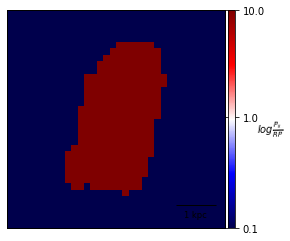

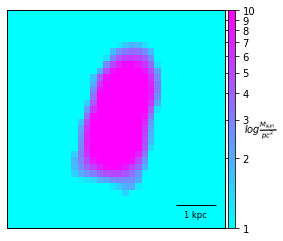

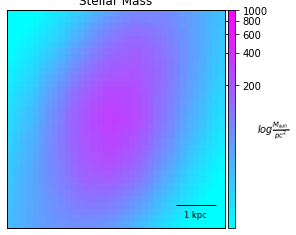

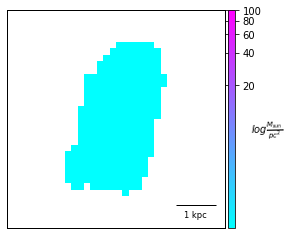

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


0.03035240271184302


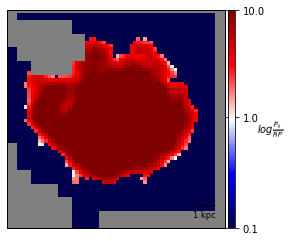

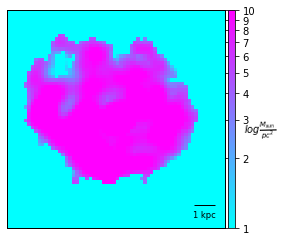

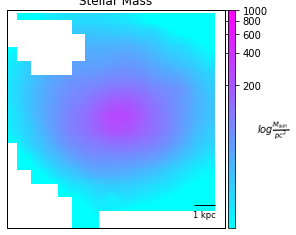

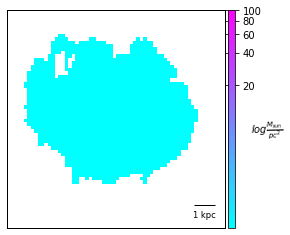

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


4.8600723290532315


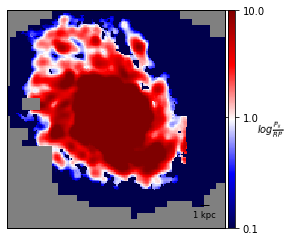

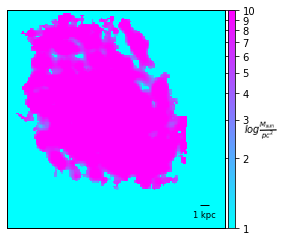

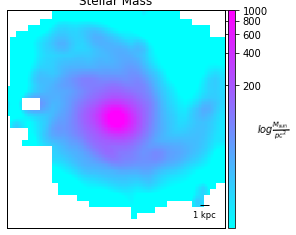

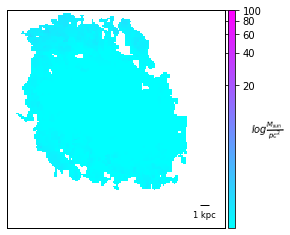

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


0.004548933491426574


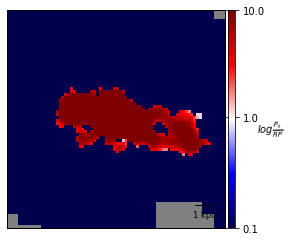

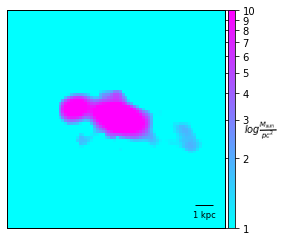

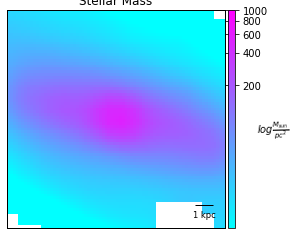

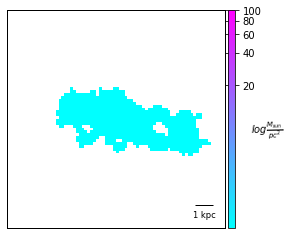

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


61.076395281479876


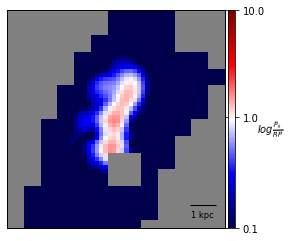

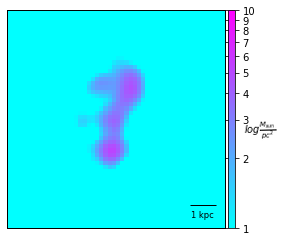

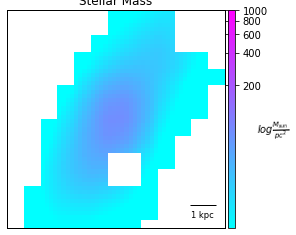

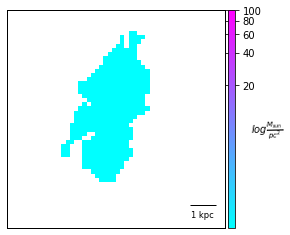

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


0.0


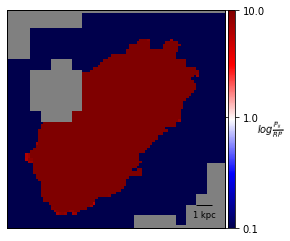

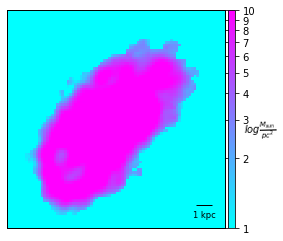

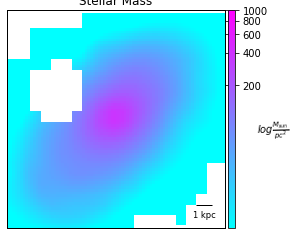

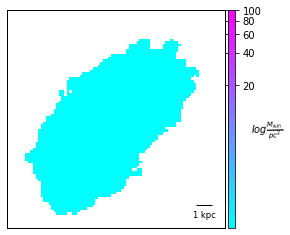

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


37.15066419677513


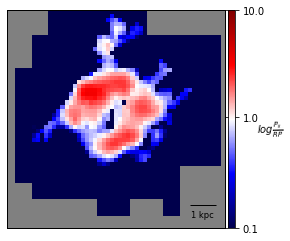

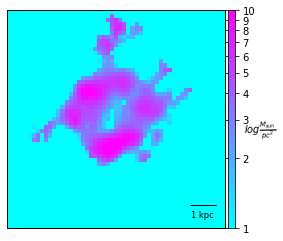

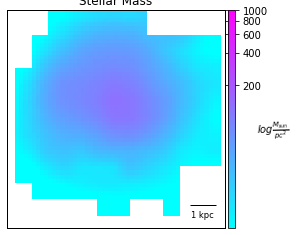

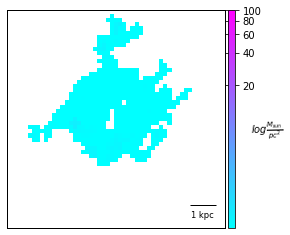

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


65.00363645577279


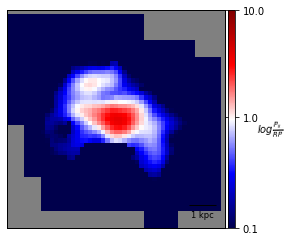

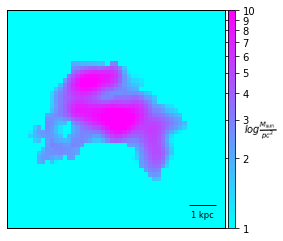

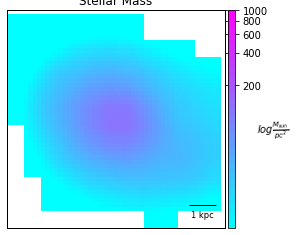

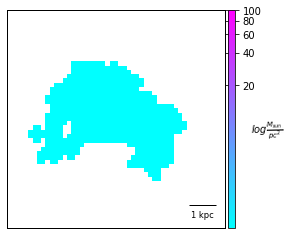

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


0.18319811958263083


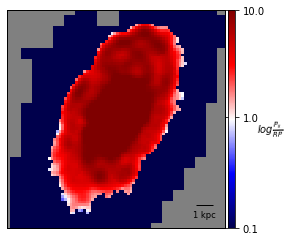

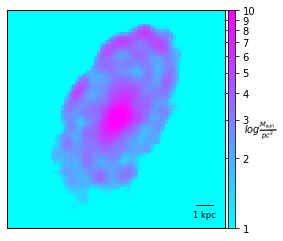

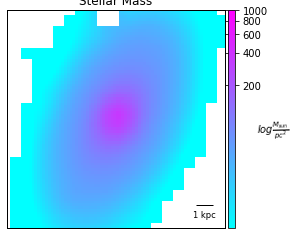

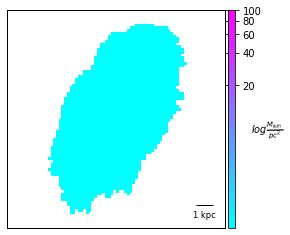

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


0.053248237235035814


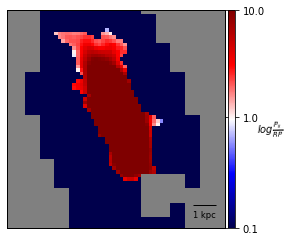

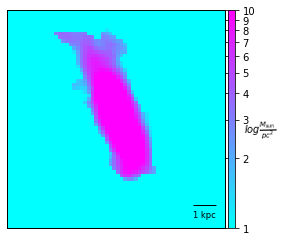

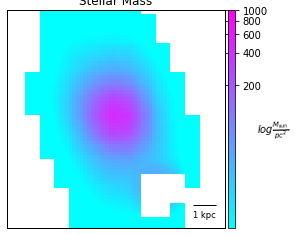

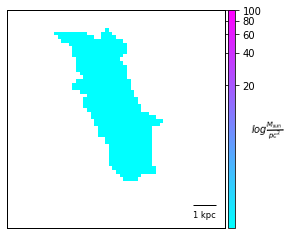

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


-0.018395560057341036


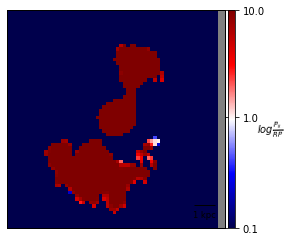

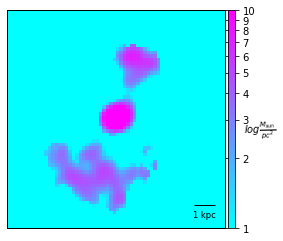

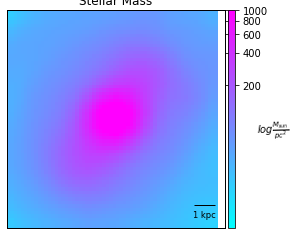

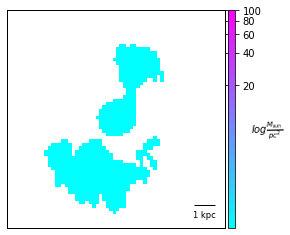

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


0.0


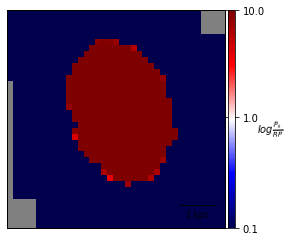

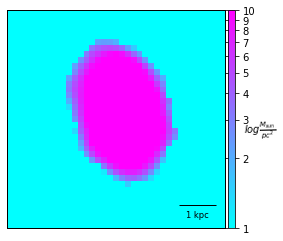

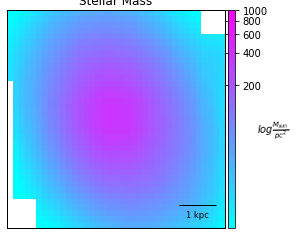

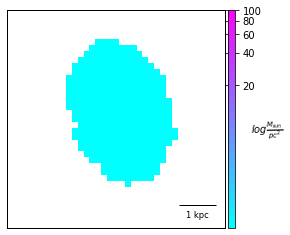

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


7.451243017301173


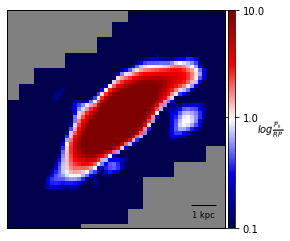

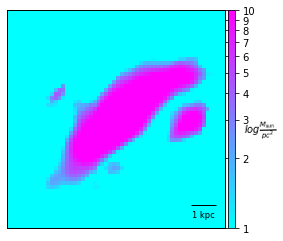

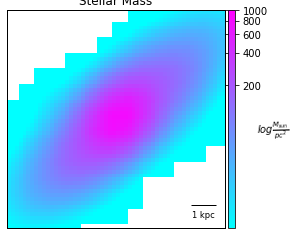

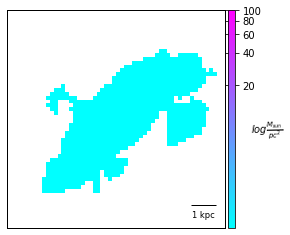

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


4.143739193212274


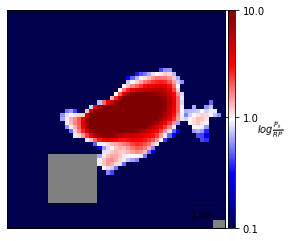

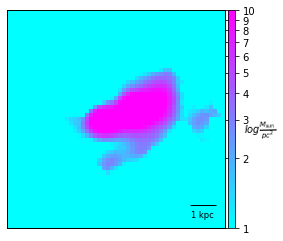

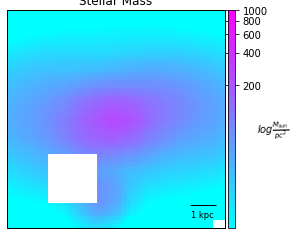

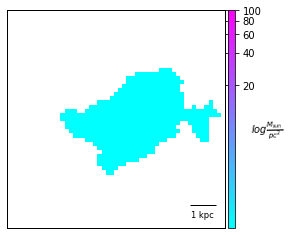

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


0.021580199894929323


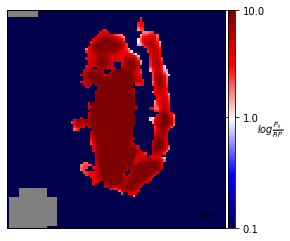

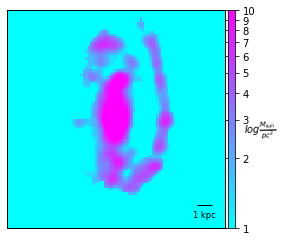

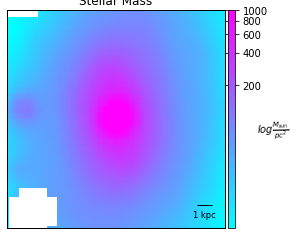

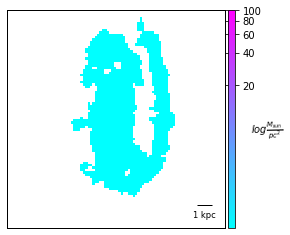

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


0.0


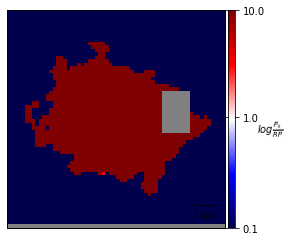

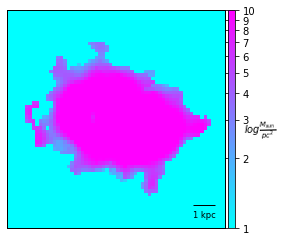

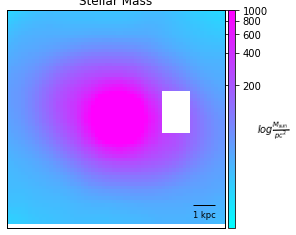

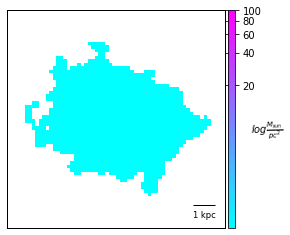

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


0.27506417938746974


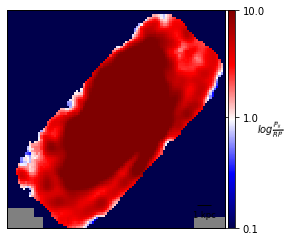

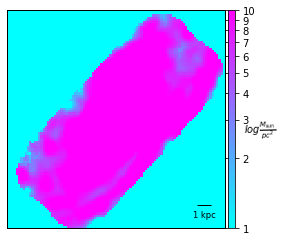

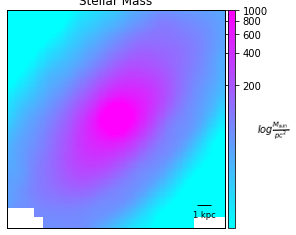

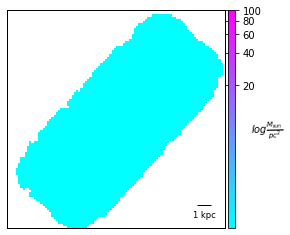

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


3.835887388993568


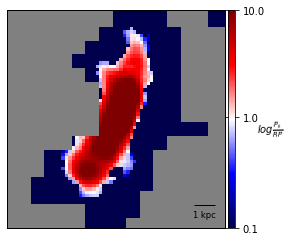

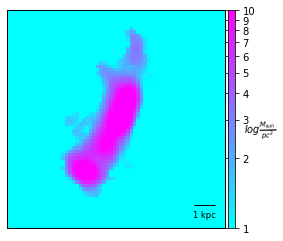

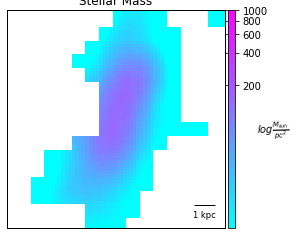

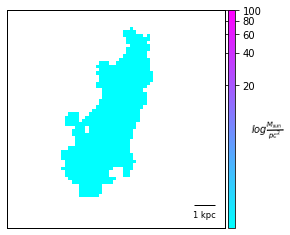

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


0.06662164816895753


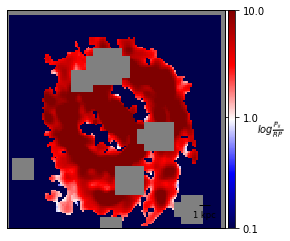

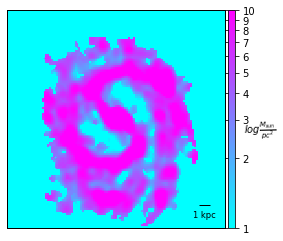

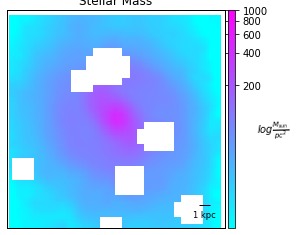

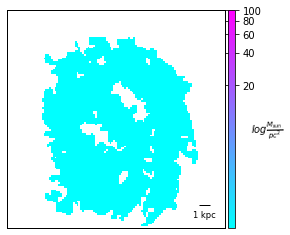

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


6.299052578117707


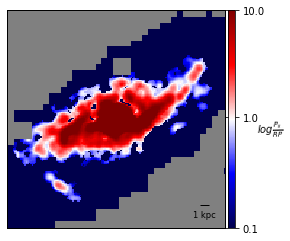

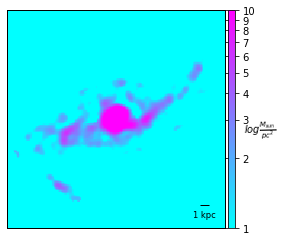

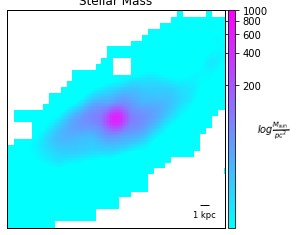

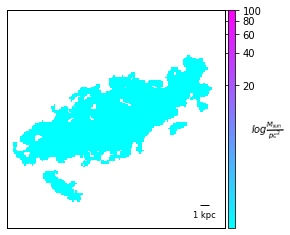

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


5.052216153520733


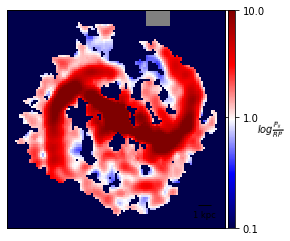

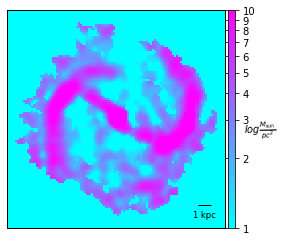

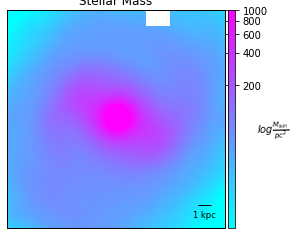

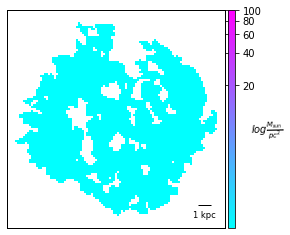

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


-0.31579678541005113


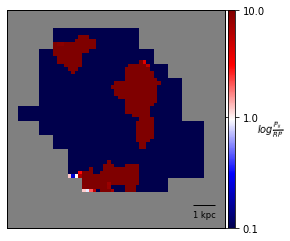

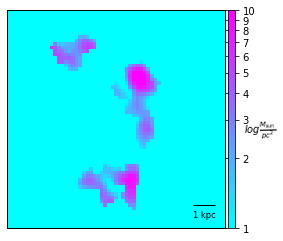

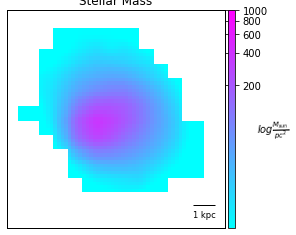

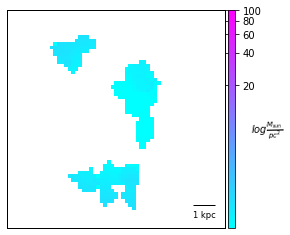

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


4.342792269048405


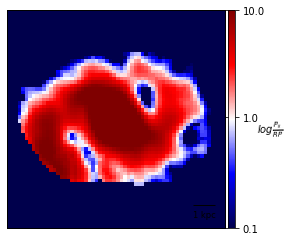

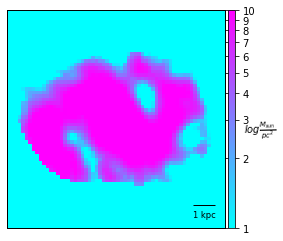

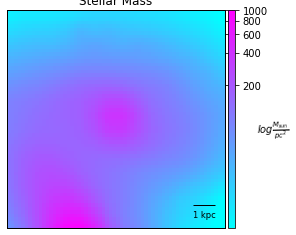

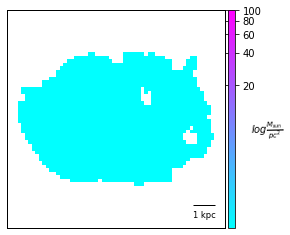

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


7.9188599642069875


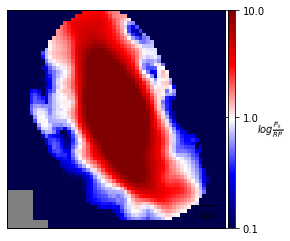

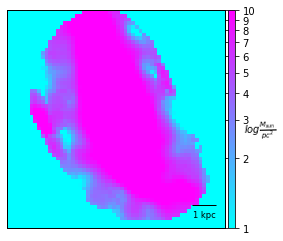

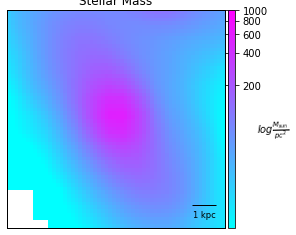

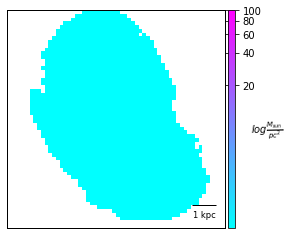

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


15.04888924194514


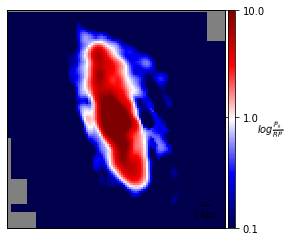

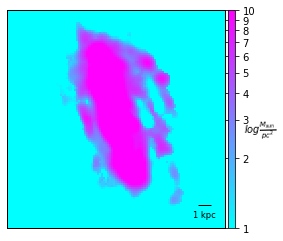

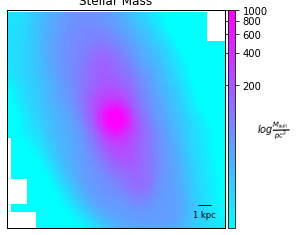

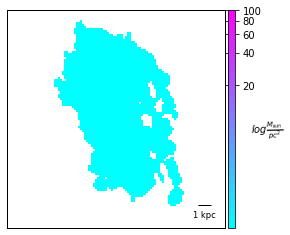

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


0.0


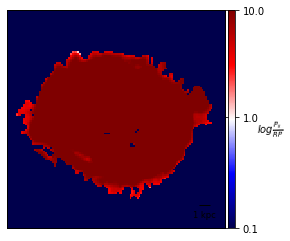

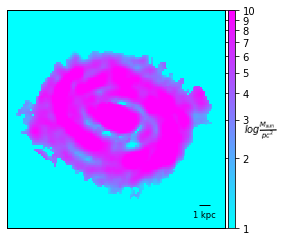

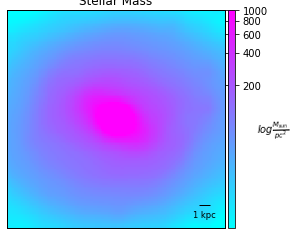

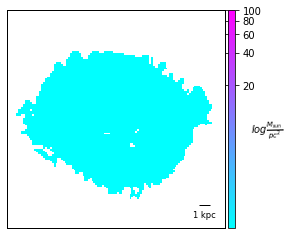

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


0.0


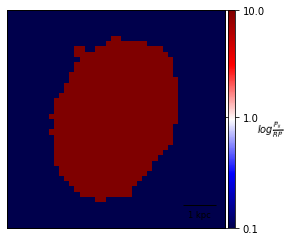

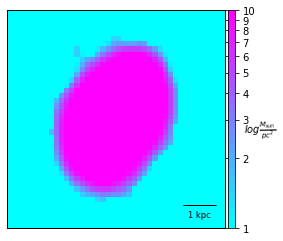

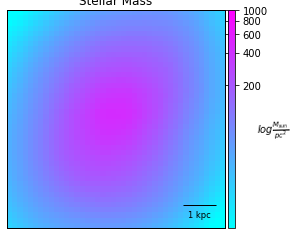

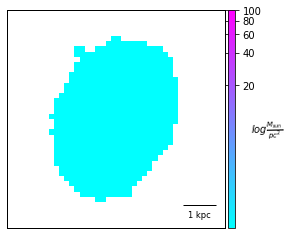

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


5.724940184168346


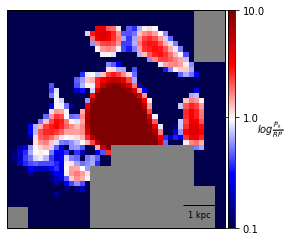

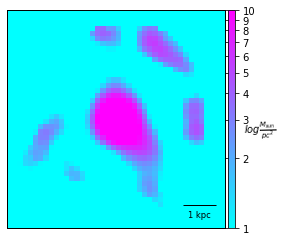

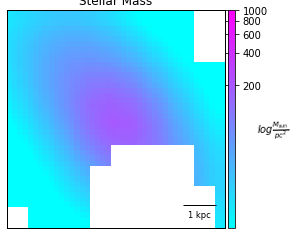

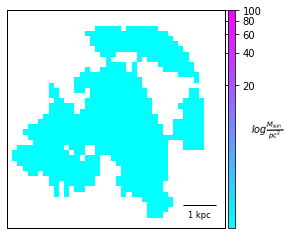

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


0.0


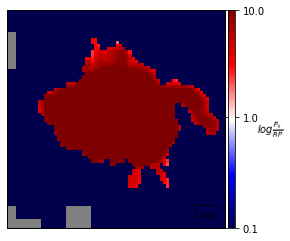

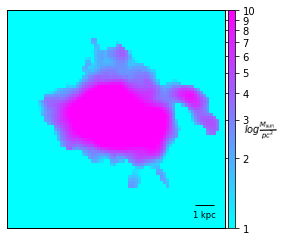

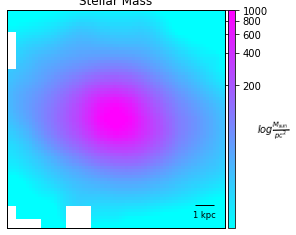

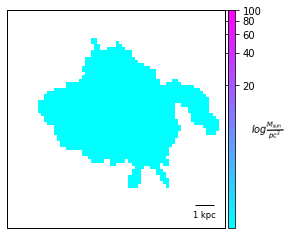

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


0.02033464412701004


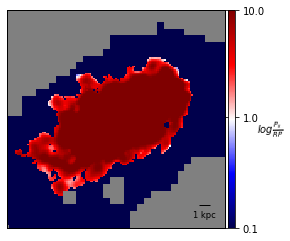

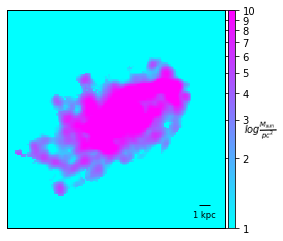

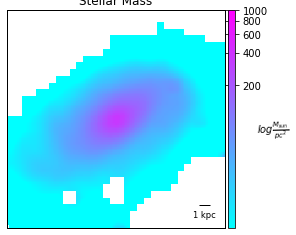

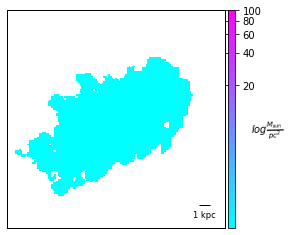

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


0.0


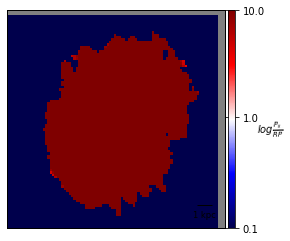

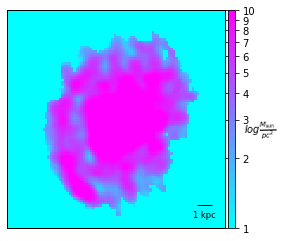

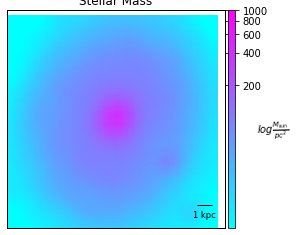

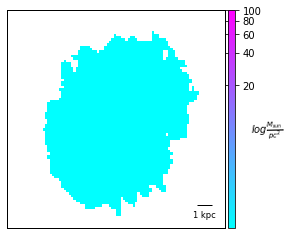

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


-0.11399577109156654


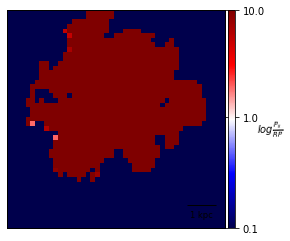

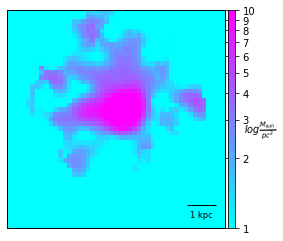

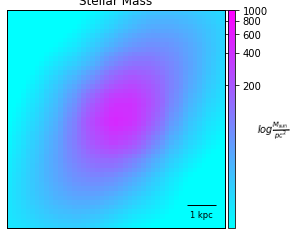

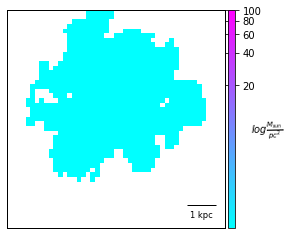

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


0.0


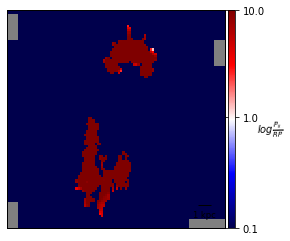

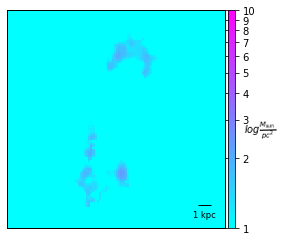

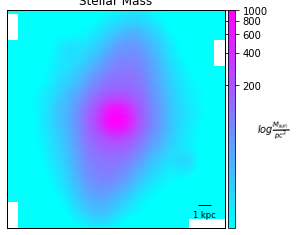

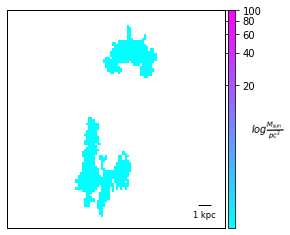

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


0.0159898502328784


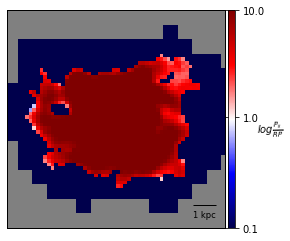

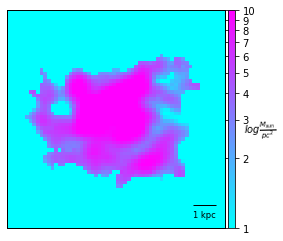

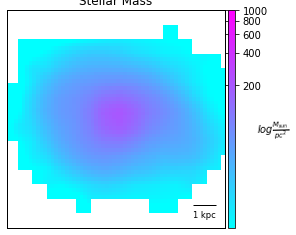

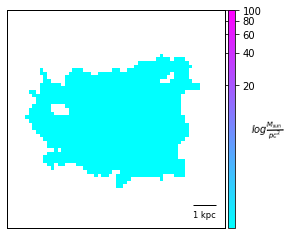

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


-0.004882971885551494


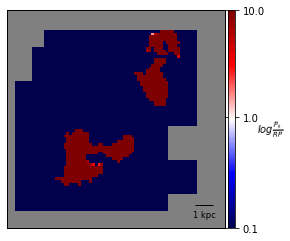

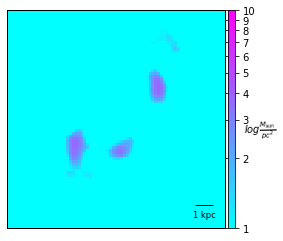

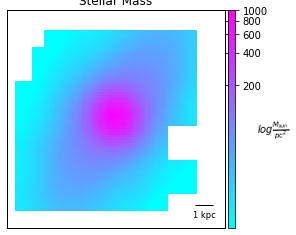

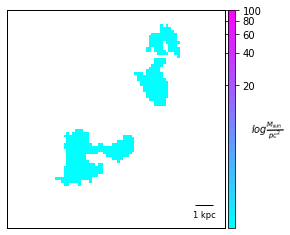

/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/astro/astro/home/greisc1/Project/Code/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  


1.2590917530720973


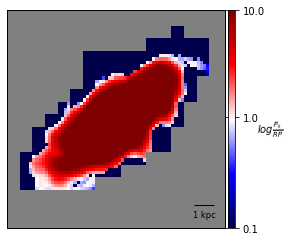

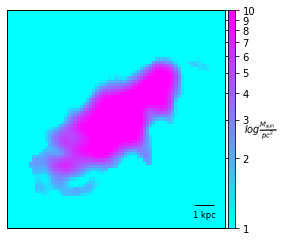

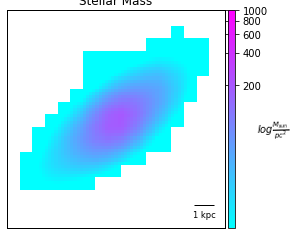

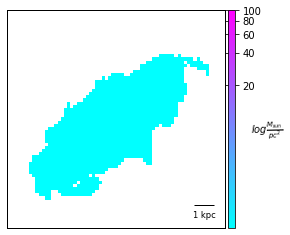

In [22]:
def plot_image(galaxy, sigma_s, sigma_mol, tot_mol, e_sigma_mol, hdr_mol, v_ICM, d_center, resolution,Type):
    #P_s, P_RP, rho_ICM, div, strip_perc = Edge_On_Pressure(galaxy,resolution, sigma_s, sigma_mol, tot_mol, hdr_mol, v_ICM, d_center,e_sigma_mol,Type)
    P_s, P_RP, rho_ICM, div, strip_perc = Pressure(sigma_s, sigma_mol, tot_mol, hdr_mol, v_ICM,d_center,phi,e_sigma_mol, Type)
    print(strip_perc)
    cmap1 = mpl.cm.get_cmap('seismic')
    cmap1.set_bad(color='grey') 

    fits1 = fits.PrimaryHDU(data=div , header=hdr_mol)
    fig = plt.figure()
    f1 = aplpy.FITSFigure(fits1, figure=fig)
    f1.show_colorscale(cmap = cmap1, stretch='log',vmin = 0.1,vmid=0.01, vmax = 10)
    basic_plot(f1,1,40, 60,hdr_mol)
    f1.colorbar.show(location='right', width=0.1, ticks=[0.1, 1, 10], labels=True, axis_label_text=r'$log\frac{P_s}{RP}$', axis_label_rotation=True)


    fits2 = fits.PrimaryHDU(data=sigma_mol , header=hdr_mol)
    fig = plt.figure()
    f2 = aplpy.FITSFigure(fits2, figure=fig)
    f2.show_colorscale(cmap = 'cool',stretch='log',vmin = (1),vmid=(0.1), vmax = 10)
    basic_plot(f2,1,40, 60,hdr_mol)
    f2.colorbar.show(location='right', width=0.1, axis_label_text=r'$log\frac{M_{sun}}{pc^2}$', axis_label_rotation=True)


    fits3 = fits.PrimaryHDU(data=sigma_s , header=hdr_mol)
    fig = plt.figure()
    f3 = aplpy.FITSFigure(fits3, figure=fig)
    f3.show_colorscale(cmap = 'cool',stretch='log',vmin = 10,vmid=1, vmax = 1000)
    basic_plot(f3,1,40, 60,hdr_mol)
    f3.colorbar.show(location='right', width=0.1, axis_label_text=r'$log\frac{M_{sun}}{pc^2}$', axis_label_rotation=True)
    f3.set_title('Stellar Mass')


    fits4 = fits.PrimaryHDU(data=e_sigma_mol , header=hdr_mol)
    fig = plt.figure()
    f4 = aplpy.FITSFigure(fits4, figure=fig)
    f4.show_colorscale(cmap = 'cool',stretch='log',vmin = 1,vmid=0.1, vmax = 100)
    basic_plot(f4,1,40, 60,hdr_mol)
    f4.colorbar.show(location='right', width=0.1, axis_label_text=r'$log\frac{M_{sun}}{pc^2}$', axis_label_rotation=True)
    plt.show()


phi =0
resolution ='VERTICO_9as'
Type= 'Trust broad'

for i in range(len(galaxies)):
    galaxy = galaxies[i]
    ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
    if resolution == 'PHANGS_high':
        ra,dec,incl,posang,r_eff, r_25 = PHANGS_data(galaxy)

    v_ICM = np.sqrt(3)*v_gal
    d_center = d_proj*np.pi/2

    if os.path.isfile(Mol_Gas_file(galaxy, resolution)) and incl < incl_cut:
        sigma_s, sigma_mol, hdr,tot_mol = data_maps(galaxy, resolution, ra, dec, incl, posang)
        e_sigma_mol = e_data_maps(galaxy, resolution, ra, dec, incl, posang)
        plot_image(galaxy, sigma_s, sigma_mol, tot_mol, e_sigma_mol, hdr, v_ICM, d_center, resolution, Type)

In [ ]:

table = Table.read(loc + 'Project/Data/phangs_sample_table_v1p6.fits', format ='fits')


#print(table.colnames)
#print(table.dtype)

In [ ]:

def histo_suscept(galaxies, phi, resolution, incl_cut,Type):
    '''Plot histogram of susceptibility percentage distribution. Important default is most likely v and d: v_ICM = np.sqrt(3)*v_gal
    d_center = d_proj*np.pi/2'''
    
    susc_lst = []
    galaxy_lst=[]
    
    for i in range(len(galaxies)):
        galaxy = galaxies[i]
        ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
        if resolution == 'PHANGS_high':
            ra,dec,incl,posang,r_eff, r_25 = PHANGS_data(galaxy)

        
        if os.path.isfile(Mol_Gas_file(galaxy, resolution)) and incl < incl_cut:
            sigma_s, sigma_mol, hdr_mol,tot_mol = data_maps(galaxy, resolution, incl)
            e_sigma_mol = e_data_maps(galaxy, resolution, incl)
            v_ICM = np.sqrt(3)*v_gal
            d_center = d_proj*np.pi/2
            P_s, P_RP, rho_ICM, div, strip_perc = Pressure(sigma_s, sigma_mol, tot_mol, hdr_mol, v_ICM, d_center,phi,e_sigma_mol,Type)
            
            susc_lst.append(strip_perc)
            galaxy_lst.append(galaxy)

    
    

    strip_3 = np.where(np.array(susc_lst) < 1, 1,0)
    bins = [1,3,10,30,100]
    # Set the figure size
    plt.figure(figsize=(7, 10))

# Create a subplot with a shorter x-axis
    #ax = plt.subplot(111, aspect='equal')

# Plot the histogram
    plt.hist(susc_lst, bins=bins, color='lightblue', edgecolor='black')
    plt.xscale('log')
    #plt.legend([r'$N_{tot} = $'+ str(len(susc_lst)) +r' and $N_{< 0.1 \%} =$'+str(np.sum(strip_3))])
    plt.bar(0.5,np.sum(strip_3),width = 1, hatch ='/',edgecolor='black', alpha = 0.5, color ='lightblue', label ='Susceptible Molecular Gas < 1%')
    #plt.text(0.6, 5, 'Susceptible Molecular Gas < 1%', rotation='vertical', ha='center', va='bottom',fontsize=18)

    plt.xticks([ 1,10, 100], [ '1', '10', '100'])
    plt.legend()

    
    plt.xlim(0.3, 100)
    plt.ylim(0,np.sum(strip_3)+1)
    plt.xlabel('Susceptible Molecular Gas [%]')
    plt.ylabel('Number of Galaxies')
    #plt.title(f'{resolution}: Wind-Impact-Angle = {phi}°')  
    plt.show()
    plt.close()

    return


Type= 'Trust broad'
resolution = 'VERTICO_9as'

#histo_suscept(galaxies, 0, 'PHANGS_high', incl_cut,Type)
#histo_suscept(galaxies, 30, 'PHANGS_high', incl_cut,Type)
histo_suscept(galaxies, 0, resolution, incl_cut,Type)
#histo_suscept(galaxies, 30, resolution, incl_cut,Type)
#histo_suscept(galaxies, 60, resolution, incl_cut,Type)

In [ ]:
def worry_pixel(galaxy,resolution, v_M87, d_sun_M87, v_ICM, d_center, phi,Type):
    '''test for pixel that we can't trust. Prints the pixel where we don't know the true value 
    (3 e_sigma_mol> sigma_mol) and where 3*e_sigma_mol would be resisistent to RPS
    --> gives three options: 1. lower limit: make them resistent, 
    2. don't take them into account, 3. make them susceptibele
    '''
    ra,dec,incl,posang,r_eff, r_25 = PHANGS_data(galaxy)
    e_sigma_mol = e_data_maps(galaxy, resolution, incl)
    sigma_s, sigma_mol, hdr,tot_mol = data_maps(galaxy, resolution, incl)
    P_s, P_RP, rho_ICM, div, strip_perc = Pressure(sigma_s, sigma_mol, tot_mol,hdr, v_ICM, d_center, phi,e_sigma_mol, Type)
    P_RP = np.full_like(P_s, P_RP) 

    g_s = (2*const.G*sigma_s* u.solMass/u.parsec**2*np.pi).to(u.m/u.s**2)  #restoring force stellar mass
    sigma_mol_max = (P_RP/g_s).to(u.solMass/u.parsec**2).value
    sigma_mol_3 = 3*e_sigma_mol

    worry = np.where((sigma_mol < sigma_mol_3 ) & (sigma_mol_max > sigma_mol_3), sigma_mol, np.nan)
    worry2 = np.where((sigma_mol < sigma_mol_3 ) & (sigma_mol_max < sigma_mol_3), sigma_mol, np.nan)
    count = np.sum(~np.isnan(worry))
    print(count)
    fits1 = fits.PrimaryHDU(data=worry , header=hdr)

    fig = plt.figure()
    f1 = aplpy.FITSFigure(fits1, figure=fig)
    cmap1 = mpl.cm.get_cmap('seismic')
    cmap1.set_bad(color='grey') 
    #f1.add_label()
    f1.show_colorscale(cmap = 'cool',stretch='log',vmin = 1,vmid=0.1, vmax = 100)
    basic_plot(f1, 1,ra,dec,hdr)

    f1.colorbar.show(location='right', width=0.1, labels=True, axis_label_text=r'$Worry-Pixel$', axis_label_rotation=True)
    f1.set_title(f'sigma_mol_max > 3* e_sigma_mol   Pixel = {count}')
    fig.suptitle(str(galaxy))
    
    fits2 = fits.PrimaryHDU(data=worry2 , header=hdr)

    fig = plt.figure()
    f2 = aplpy.FITSFigure(fits2, figure=fig)
    cmap2 = mpl.cm.get_cmap('seismic')
    cmap2.set_bad(color='grey') 
    #f1.add_label()
    f2.show_colorscale(cmap = 'cool',stretch='log',vmin = 1,vmid=0.1, vmax = 100)
    basic_plot(f2, 1,ra,dec,hdr)

    f2.colorbar.show(location='right', width=0.1, labels=True, axis_label_text=r'$Worry-Pixel$', axis_label_rotation=True)
    f2.set_title(f'sigma_mol_max < 3 * e_sigma_mol')
    fig.suptitle(str(galaxy))

    return 


incl_cut = 75
resolution = 'PHANGS_high'
phi = 0
Type = 'Trust broad'

for i in range(len(galaxies)):
        galaxy = galaxies[i]
        ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
        v_ICM = np.sqrt(3)*v_gal
        d_center = d_proj*np.pi/2
        
        if os.path.isfile(Mol_Gas_file(galaxy, resolution)) and incl < incl_cut:
            worry_pixel(galaxy,resolution, v_M87, d_sun_M87, v_ICM, d_center, phi, Type)
            
#one galaxy      
'''galaxy = 'NGC4569'
ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
v_ICM = np.sqrt(3)*v_gal
d_center = d_proj*np.pi/2
worry_pixel(galaxy,resolution, v_M87, d_sun_M87, v_ICM, d_center, phi)'''

In [ ]:

def radial_stripping(galaxy, color, phi, sigma_s, sigma_mol, tot_mol, hdr, e_sigma_mol,v_ICM,d_center,ra,dec,incl, posang, Plot_Type, Type):
    '''If Plot_Type = 'single' it returns a plot for a galaxy 
    Susceptible gas , Mol Gas, Pixel number and Susceptible Gas profiles.
    Else it plots all Susceptible percentage profiles in one plot.
    Insert different sigma_mol (broad, strict, upper limits)'''
    
    P_s, P_RP, rho_ICM, div, strip_perc = Pressure(sigma_s, sigma_mol, tot_mol, hdr, v_ICM,d_center,phi,e_sigma_mol,Type)
    _,_,_,_,r_eff, r_25 = PHANGS_data(galaxy)
    zabel = Zabel_table1(galaxy)  
    VERTICOIV = VERTICOIV_table1(galaxy)
    l_mol = VERTICOIV['l_mol']*1000
    R_e_mol = VERTICOIV['R_e_mol']*1000


    R_star = zabel['R_star']
    R_star = float(R_star)*1000 # make kpc to pc
    r_eff = np.deg2rad(r_eff/3600)*d_sun_M87.to('parsec').value #convert from arcsec to parsec
    r_25 = np.deg2rad(r_25/3600)*d_sun_M87.to('parsec').value #convert from arcsec to parsec

    r_array,_ = deproject((ra*u.deg,dec*u.deg),incl*u.deg, posang*u.deg, header=hdr) #get r in deg
    r_array= (np.deg2rad(np.array(r_array))*d_sun_M87.to('pc')).flatten() #r in physical units

    #strip mol where div <= 0 & flatten those arrays
    strip_mol = np.where(div<=1,sigma_mol,0).flatten()
    sigma_mol= np.array(sigma_mol).flatten()    
    e_sigma_mol= np.array(e_sigma_mol).flatten()

    #Define bins - length in units of pc
    bin_edges = np.arange(0, max(r_array.value), 1000) #500pc steps
    pixel_bin, _ = np.histogram(r_array.value[~np.isnan(sigma_mol)], bins=bin_edges)
    bin_tot_mol, _ = np.histogram(r_array.value[~np.isnan(sigma_mol)], bins=bin_edges, weights=sigma_mol[~np.isnan(sigma_mol)])
    bin_strip, _ = np.histogram(r_array.value[~np.isnan(sigma_mol)], bins=bin_edges, weights=strip_mol[~np.isnan(sigma_mol)])

    var_bin_tot_mol, _ = np.histogram(r_array.value[~np.isnan(sigma_mol)], bins=bin_edges, weights=np.square(e_sigma_mol)[~np.isnan(sigma_mol)])
    e_bin = np.sqrt(var_bin_tot_mol)
    d_d_bin_strip = np.divide(np.ones_like(bin_tot_mol),bin_tot_mol,out=np.zeros_like(bin_tot_mol), where=(bin_tot_mol != 0))
    d_d_bin_tot_mol = np.divide(bin_strip,bin_tot_mol**2,out=np.zeros_like(bin_strip), where=(bin_tot_mol != 0))


    percentage = 100*(np.divide(bin_strip,bin_tot_mol,out=np.zeros_like(bin_strip), where=(bin_tot_mol != 0))) #100*(1-(bin_non_strip/bin_tot_mol))
    e_percentage = 100*np.sqrt(d_d_bin_strip**2*e_bin**2+d_d_bin_tot_mol**2*e_bin**2) #error
    stop_index = len(percentage)
    #don't want the profile where it drops
    for i in range(1, len(percentage) - 1):
        if percentage[i] < percentage[i - 1] and (percentage[i + 1] < percentage[i] or percentage[i + 1] == percentage[i]):
            stop_index = i 
            break

    bin_edges = bin_edges[:stop_index]
    percentage = percentage[:stop_index]
    e_percentage = e_percentage[:stop_index]
    #------Plotting-----------
    if Plot_Type == 'single':
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))

        #-------------Percentage Susceptible Mol Gas-----
        axs[0, 0].step(bin_edges[:-1]/R_star, percentage, where='post', color=color, label=str(galaxy))
        axs[0, 0].errorbar((bin_edges[:-1]+np.diff(bin_edges)/2)/R_star, percentage, yerr=e_percentage, fmt='none', c='k')
        axs[0, 0].set_ylim(min(percentage), 110)
        axs[0, 0].set_xlabel(r"Radius [$R/R_{*}$]")
        axs[0, 0].set_ylabel(r'Susceptible Mol Gas [%]')
        axs[0, 0].set_title(r'Percentage Susceptible Gas')
        axs[0, 0].legend()

        #----------------Total Molecular Gas-----
        axs[0, 1].step(bin_edges[:-1]/R_star, bin_tot_mol/pixel_bin, where='post', color=color, label=str(galaxy))
        axs[0, 1].errorbar((bin_edges[:-1]+np.diff(bin_edges)/2)/R_star, bin_tot_mol, yerr=d_d_bin_tot_mol, fmt='none', c='k')
        axs[0, 1].set_xlabel(r"Radius [$R/R_{*}$]")
        axs[0, 1].set_ylim(min(bin_tot_mol/pixel_bin),max(bin_tot_mol/pixel_bin))
        axs[0, 1].set_ylabel(r'Average Mol Gas/pixel [$M_{Sol}$]')
        axs[0, 1].set_title(r'Mol Gas')
        axs[0, 1].legend()

        #--------------Stripped Gas-----
        axs[1, 1].step(bin_edges[:-1]/R_star, bin_strip/pixel_bin, where='post', color=color, label=str(galaxy))
        axs[1, 1].errorbar((bin_edges[:-1]+np.diff(bin_edges)/2)/R_star, bin_strip, yerr=d_d_bin_strip, fmt='none', c='k')
        axs[1, 1].set_xlabel(r"Radius [$R/R_{*}$]")
        axs[1, 1].set_ylim(min(bin_strip/pixel_bin),max(bin_strip/pixel_bin))
        axs[1, 1].set_ylabel(r'Average Susceptible Mol Gas/Pixel [$M_{Sol}$]')
        axs[1, 1].set_title('Susceptible Mol Gas')
        axs[1, 1].legend()

        #--------------Number of Pixel-----
        axs[1, 0].step(bin_edges[:-1]/R_star, pixel_bin, where='post', color=color, label=str(galaxy))
        axs[1, 0].set_xlabel(r"Radius [$R/R_{*}$]")
        axs[1, 0].set_ylabel(r'Number of Pixel')
        axs[1, 0].set_title('Number of Pixel')
        axs[1, 0].legend()

        # Adjust the spacing between subplots
        plt.tight_layout()

        # Show the figure
        plt.show()
        plt.close()

    else:
      #-------------Percentage Susceptible Mol Gas-----
        if not math.isnan(l_mol):
            
            plt.step(np.divide(bin_edges,R_e_mol),percentage,where='post',color = 'grey')
            plt.step(np.divide(bin_edges,R_e_mol),percentage,where='post',color = color)
            #plt.errorbar((bin_edges[:-1]+np.diff(bin_edges)/2)/R_star, percentage, yerr=e_percentage, fmt='none', c='k')


            plt.ylim(-10,110)
            plt.xlim(0,6)

            # Add labels to the x and y axes and the title
            plt.xlabel(r"Radius [$R/R_{mol}$]")
            plt.ylabel(r'Susceptible Mol Gas [%]')
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)


    return 



Plot single Galaxies with Mol Gas, Pixel number and Susceptible Gas profiles using broad data

In [ ]:
phi = 0
resolution ='VERTICO_9as'
incl_cut = 75
#color_lst = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','lightblue','yellow']
count = 0
Type ='Trust broad'
colormap = plt.cm.get_cmap('PuRd')  # Choose a colormap (e.g., 'viridis')

min_color_bar = 0.1
max_color_bar = 100

for i in range(len(galaxies)):
    galaxy = galaxies[i]
    ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
    if resolution == 'PHANGS_high':
        ra,dec,incl,posang,r_eff, r_25 = PHANGS_data(galaxy)

    v_ICM = np.sqrt(3)*v_gal
    d_center = d_proj*np.pi/2

    if os.path.isfile(Mol_Gas_file(galaxy, resolution)) and incl < incl_cut:
        sigma_s, sigma_mol, hdr, tot_mol = data_maps(galaxy, resolution, incl)
        e_sigma_mol = e_data_maps(galaxy, resolution, incl)
        P_s, P_RP, rho_ICM, div, strip_perc_trust = Pressure(sigma_s, sigma_mol, tot_mol, hdr, v_ICM, d_center,phi, e_sigma_mol, Type)
        color = 'grey'
        if strip_perc_trust>0:

            color= colormap((np.log(strip_perc_trust) - np.log(min_color_bar)) / (np.log(max_color_bar) - np.log(min_color_bar)))
        count+=1
        radial_stripping(galaxy, color, phi, sigma_s, sigma_mol, tot_mol, hdr, e_sigma_mol, v_ICM,d_center,ra,dec,incl, posang,'-', Type)
# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=colormap, norm=colors.LogNorm(vmin=min_color_bar, vmax=max_color_bar))
sm.set_array([])
plt.colorbar(sm, label='Total Susceptible Molecular Gas [%]')
plt.show()


In [ ]:
phi = 0
resolution ='PHANGS_high'
incl_cut = 75
#color_lst = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','lightblue','yellow']
count = 0
Type ='Trust broad'

for i in range(len(galaxies)):
    galaxy = galaxies[i]
    ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
    if resolution == 'PHANGS_high':
        ra,dec,incl,posang,r_eff, r_25 = PHANGS_data(galaxy)

    v_ICM = np.sqrt(3)*v_gal
    d_center = d_proj*np.pi/2

    if os.path.isfile(Mol_Gas_file(galaxy, resolution)) and incl < incl_cut:
        sigma_s, sigma_mol, hdr, tot_mol = data_maps(galaxy, resolution, incl)
        e_sigma_mol = e_data_maps(galaxy, resolution, incl)
        color= color_lst[count]
        count+=1
        print(galaxy)
        
        radial_stripping(galaxy, color, phi, sigma_s, sigma_mol, tot_mol, hdr, e_sigma_mol, v_ICM,d_center,ra,dec,incl, posang,'single', Type)




In [ ]:
phi = 0
resolution ='PHANGS_high'
incl_cut = 75
color_lst = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','lightblue','yellow']
count = 0
Type ='Trust broad'


for i in range(len(galaxies)):
    galaxy = galaxies[i]
    ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
    if resolution == 'PHANGS_high':
        ra,dec,incl,posang,r_eff, r_25 = PHANGS_data(galaxy)

    v_ICM = np.sqrt(3)*v_gal
    d_center = d_proj*np.pi/2

    if os.path.isfile(Mol_Gas_file(galaxy, resolution)) and incl < incl_cut:
        sigma_s, sigma_mol, hdr,tot_mol = data_maps(galaxy, resolution, incl)
        e_sigma_mol = e_data_maps(galaxy, resolution, incl)
        sigma_mol_strict = sigma_mol_limits(sigma_mol, e_sigma_mol,'strict')

        color= color_lst[count]
        count+=1
        print(galaxy)
        
        radial_stripping(galaxy, color, phi, sigma_s, sigma_mol_strict, tot_mol, hdr, e_sigma_mol, v_ICM,d_center,ra,dec,incl, posang,'single', Type)





Plot all PHANGS-galaxies (Susceptible Mol Gas Rarial Profiles) in one Plot for three cases: trusting broad, strict and upper limit

Check the systematic effects of the wind-impact angle, velocity and projected distance

In [ ]:
def susceptible_phi_plot(galaxy, phi_lst, color,sigma_s, sigma_mol, tot_mol, hdr, v_ICM,d_center, e_sigma_mol, Type):
    
    P_s, P_RP, rho_ICM, div, susc_perc1= Pressure(sigma_s, sigma_mol, tot_mol, hdr, v_ICM,d_center,phi_lst[0], e_sigma_mol, Type)
    P_s, P_RP, rho_ICM, div, susc_perc2= Pressure(sigma_s, sigma_mol, tot_mol, hdr, v_ICM,d_center,phi_lst[1], e_sigma_mol, Type)
    P_s, P_RP, rho_ICM, div, susc_perc3=  Pressure(sigma_s, sigma_mol, tot_mol, hdr, v_ICM,d_center,phi_lst[2], e_sigma_mol, Type)
    P_s, P_RP, rho_ICM, div, susc_perc4 = Pressure(sigma_s, sigma_mol, tot_mol, hdr, v_ICM,d_center,phi_lst[3], e_sigma_mol, Type)
    #P_s, P_RP, rho_ICM, div,percentage_edge_on = Edge_On_Pressure(galaxy,resolution, sigma_s, sigma_mol, tot_mol, hdr, v_ICM, d_center, e_sigma_mol, Type)
    
    #---correct RPF function with cos(phi) of velocity
    susc_perc_lst =[susc_perc1,susc_perc2,susc_perc3,susc_perc4]
    plt.plot(phi_lst,susc_perc_lst, marker ='o', color =color,linestyle='-', linewidth=0.5, label=f'NGC{galaxy[3:]}')
    #plt.plot(90,percentage_edge_on, marker ='*', color =color,linestyle=' ')

    plt.xlabel('Wind-Impact-Angle [deg]')
    plt.ylabel('Susceptible Molecular Gas [%]')
    plt.xticks([0,30,60, 90])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)    



Effect of the Wind-impact angle using broad data

In [ ]:
resolution ='PHANGS_high'
Type = 'Trust broad'
incl_cut = 75
count = 0
phi_lst= [0,30,60,90]
#-------TRUST BROAD------
for i in range(len(galaxies)):
    galaxy = galaxies[i]
    ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
    if resolution == 'PHANGS_high':
        ra,dec,incl,posang,r_eff, r_25 = PHANGS_data(galaxy)

    v_ICM = np.sqrt(3)*v_gal
    d_center = d_proj*np.pi/2

    if os.path.isfile(Mol_Gas_file(galaxy, resolution)) and incl < incl_cut:
        sigma_s, sigma_mol, hdr, tot_mol = data_maps(galaxy, resolution, incl)
        e_sigma_mol = e_data_maps(galaxy, resolution, incl)


        color= color_lst[count]
        count+=1
        susceptible_phi_plot(galaxy, phi_lst, color,sigma_s, sigma_mol, tot_mol, hdr, v_ICM,d_center, e_sigma_mol, Type)
        plt.title('Trust Broad')
plt.show()

#----------STRICT-------
count = 0
for i in range(len(galaxies)):
    galaxy = galaxies[i]
    ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
    if resolution == 'PHANGS_high':
        ra,dec,incl,posang,r_eff, r_25 = PHANGS_data(galaxy)

    v_ICM = np.sqrt(3)*v_gal
    d_center = d_proj*np.pi/2

    if os.path.isfile(Mol_Gas_file(galaxy, resolution)) and incl < incl_cut:
        sigma_s, sigma_mol, hdr, tot_mol = data_maps(galaxy, resolution, incl)
        e_sigma_mol = e_data_maps(galaxy, resolution, incl)
        sigma_mol_3 = 3*e_sigma_mol
        sigma_mol_strict = sigma_mol_limits(sigma_mol, e_sigma_mol,'strict')


        color= color_lst[count]
        count+=1
        susceptible_phi_plot(galaxy, phi_lst, color,sigma_s, sigma_mol_strict, tot_mol, hdr, v_ICM,d_center, e_sigma_mol, Type)
        plt.title('Strict')
plt.show()


#-----UPPER LIMIT-----
#----------STRICT-------
count = 0
for i in range(len(galaxies)):
    galaxy = galaxies[i]
    ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
    if resolution == 'PHANGS_high':
        ra,dec,incl,posang,r_eff, r_25 = PHANGS_data(galaxy)

    v_ICM = np.sqrt(3)*v_gal
    d_center = d_proj*np.pi/2

    if os.path.isfile(Mol_Gas_file(galaxy, resolution)) and incl < incl_cut:
        sigma_s, sigma_mol, hdr, tot_mol = data_maps(galaxy, resolution, incl)
        e_sigma_mol = e_data_maps(galaxy, resolution, incl)
        sigma_mol_3 = 3*e_sigma_mol
        sigma_mol_upper = sigma_mol_limits(sigma_mol, e_sigma_mol,'Upper limit')


        color= color_lst[count]
        count+=1
        susceptible_phi_plot(galaxy, phi_lst, color,sigma_s, sigma_mol_upper, tot_mol, hdr, v_ICM,d_center, e_sigma_mol, Type)
        plt.title('Upper limit')
plt.show()


All in one: Wind-impact-angle with upper, broad, strict mol gas data


In [ ]:
resolution ='VERTICO_9as'
Type= 'Trust broad'
incl_cut = 75
count = 0
phi_lst= [0,30,60,90]
#-------TRUST BROAD------
for i in range(len(galaxies)):
    galaxy = galaxies[i]
    ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
    if resolution == 'PHANGS_high':
        ra,dec,incl,posang,r_eff, r_25 = PHANGS_data(galaxy)

    v_ICM = np.sqrt(3)*v_gal
    d_center = d_proj*np.pi/2

    if os.path.isfile(Mol_Gas_file(galaxy, resolution)) and incl < incl_cut:
        sigma_s, sigma_mol, hdr, tot_mol = data_maps(galaxy, resolution, incl)
        e_sigma_mol = e_data_maps(galaxy, resolution, incl)


        color= color_lst[count]
        count+=1
        susceptible_phi_plot(galaxy, phi_lst, color,sigma_s, sigma_mol, tot_mol, hdr, v_ICM,d_center, e_sigma_mol, Type)
        plt.title('Trust Broad')
plt.show()


#-------with galaxies only higher than 3%

Type= 'Trust broad'
incl_cut = 75
count = 0
phi_lst= [0,30,60,90]
#-------TRUST BROAD------
for i in range(len(galaxies)):
    galaxy = galaxies[i]
    ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
    if resolution == 'PHANGS_high':
        ra,dec,incl,posang,r_eff, r_25 = PHANGS_data(galaxy)

    v_ICM = np.sqrt(3)*v_gal
    d_center = d_proj*np.pi/2

    if os.path.isfile(Mol_Gas_file(galaxy, resolution)) and incl < incl_cut:
        sigma_s, sigma_mol, hdr, tot_mol = data_maps(galaxy, resolution, incl)
        e_sigma_mol = e_data_maps(galaxy, resolution, incl)
        P_s, P_RP, rho_ICM, div, susc_perc3= Pressure(sigma_s, sigma_mol, tot_mol, hdr, v_ICM,d_center,phi_lst[2], e_sigma_mol, Type)
        if susc_perc3 >1:



            color= color_lst[count]
            count+=1
            susceptible_phi_plot(galaxy, phi_lst, color,sigma_s, sigma_mol, tot_mol, hdr, v_ICM,d_center, e_sigma_mol, Type)
            plt.title('Phi = 60° Susceptible Mol Gas > 1%')
plt.show()

Effect of distance on Susceptible Mol Gas Percentage

In [ ]:
def susceptible_d_plot(galaxy, color,sigma_s, sigma_mol, tot_mol, hdr,v_ICM,d_proj, d_prob, r_virgo,phi, e_sigma_mol, Type):
    x_labels = ["Projected Distance", "Average Distance", "Virgo Cluster Radius"]
    x_values = [1,2,3]
    P_s, P_RP, rho_ICM, div, susc_perc1= Pressure(sigma_s, sigma_mol, tot_mol, hdr, v_ICM,d_proj,phi, e_sigma_mol, Type)
    P_s, P_RP, rho_ICM, div, susc_perc2= Pressure(sigma_s, sigma_mol, tot_mol, hdr, v_ICM,d_prob,phi, e_sigma_mol, Type)
    P_s, P_RP, rho_ICM, div, susc_perc3=  Pressure(sigma_s, sigma_mol, tot_mol, hdr, v_ICM,r_virgo,phi, e_sigma_mol, Type)
 
    #---correct RPF function with cos(phi) of velocity
    susc_perc_lst =[susc_perc1,susc_perc2,susc_perc3]
    plt.plot(x_values,susc_perc_lst, marker ='o', color =color,linestyle='-', linewidth=0.5, label=f'NGC{galaxy[3:]}')

    plt.xticks(x_values, x_labels)
    plt.ylabel('Susceptible Molecular Gas [%]')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
Type = 'Trust broad'   
resolution ='VERTICO_9as'
incl_cut = 75
count = 0
phi = 0
#-------TRUST BROAD------
for i in range(len(galaxies)):
    galaxy = galaxies[i]
    ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
    if resolution == 'PHANGS_high':
        ra,dec,incl,posang,r_eff, r_25 = PHANGS_data(galaxy)



    if os.path.isfile(Mol_Gas_file(galaxy, resolution)) and incl < incl_cut:
        sigma_s, sigma_mol, hdr, tot_mol = data_maps(galaxy, resolution, incl)
        e_sigma_mol = e_data_maps(galaxy, resolution, incl)
        v_ICM = np.sqrt(3)*v_gal
        d_prob = d_proj*np.pi/2
        color= color_lst[count]
        count+=1
        susceptible_d_plot(galaxy, color,sigma_s, sigma_mol, tot_mol, hdr, v_ICM,d_proj, d_prob, r_virgo,phi, e_sigma_mol, Type)





Effect of VELOCITY on Susceptible Mol Gas Percentage

In [ ]:
def susceptible_v_plot(galaxy, color,sigma_s, sigma_mol, tot_mol, hdr, d_center,v_gal,v_prob, v_sigma,phi, e_sigma_mol,Type):
    x_labels = ["Radial Velocity", "Isotropic Velocity", r"Radial +$\sigma$-Virgo Velocity"]
    x_values = [1,2,3]
    P_s, P_RP, rho_ICM, div, susc_perc1= Pressure(sigma_s, sigma_mol, tot_mol, hdr, v_gal,d_center,phi, e_sigma_mol, Type)
    P_s, P_RP, rho_ICM, div, susc_perc2= Pressure(sigma_s, sigma_mol, tot_mol, hdr, v_prob,d_center,phi, e_sigma_mol, Type)
    P_s, P_RP, rho_ICM, div, susc_perc3=  Pressure(sigma_s, sigma_mol, tot_mol, hdr, v_sigma,d_center,phi, e_sigma_mol, Type)
 
    #---correct RPF function with cos(phi) of velocity
    susc_perc_lst =[susc_perc1,susc_perc2,susc_perc3]
    plt.plot(x_values,susc_perc_lst, marker ='o', color =color,linestyle='-', linewidth=0.5, label=f'NGC{galaxy[3:]}')

    plt.xticks(x_values, x_labels)
    plt.ylabel('Susceptible Molecular Gas [%]')
    #plt.legend(loc='upper right', ncol=2)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)


resolution ='VERTICO_9as'
Type = 'Trust broad'
incl_cut = 75
count = 0
phi = 0
#-------TRUST BROAD------
for i in range(len(galaxies)):
    galaxy = galaxies[i]
    ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
    if resolution == 'PHANGS_high':
        ra,dec,incl,posang,r_eff, r_25 = PHANGS_data(galaxy)

    if os.path.isfile(Mol_Gas_file(galaxy, resolution)) and incl < incl_cut:
        sigma_s, sigma_mol, hdr, tot_mol = data_maps(galaxy, resolution, incl)
        e_sigma_mol = e_data_maps(galaxy, resolution, incl)
        v_prob = np.sqrt(3)*v_gal
        v_sigma = np.sqrt(v_gal**2 + 2*v_disp_virgo**2)

        d_center = d_proj*np.pi/2
        color= color_lst[count]
        count+=1

        susceptible_v_plot(galaxy, color,sigma_s, sigma_mol, tot_mol, hdr, d_center,v_gal,v_prob, v_sigma,phi, e_sigma_mol, Type)
  


PHASE SPACE DIAGRAM

In [ ]:
def phase_space(r_vir, v_disp, d_proj_lst, v_gal_lst, susc_perc_lst, galaxy_lst):
    x1 =[]
    y1=[]
    x = d_proj_lst / r_vir
    y = np.abs(v_gal_lst) / v_disp
    for i in range(len(x)):
        if susc_perc_lst[i]< 1:
            x1.append(x[i])
            y1.append(y[i])

    fig, ax = plt.subplots(figsize=(7, 5))  # Adjust the figure size as desired

    color_start = [1, 1, 1]  # RGB values for white
    color_end = [3/255, 7/255, 100/255]  # RGB values for #030764
    cmap_colors = [color_start, color_end]
    new_cmap = colors.LinearSegmentedColormap.from_list('my_colormap', cmap_colors)

    plot = ax.scatter(x, y, c=susc_perc_lst, cmap=new_cmap, edgecolor='grey', norm=colors.LogNorm(vmin=1, vmax=100), marker='*', s=400)
    plt.scatter(x1, y1, marker='*', edgecolor='grey', s=400, color='red', alpha=0.4, label=r'$< 1\%$ Susceptibility')


    cbar = fig.colorbar(plot)
    cbar.set_label(r"Susceptible Molecular Gas [%]", fontsize=16)

    # Adjust the tick labels on the colorbar
    cbar.set_ticks([1, 10, 100])
    #cbar.set_ticklabels(['1%', '10%', '100%'])
    cbar.ax.tick_params(labelsize=18)  # Increase the colorbar tick size

    plt.xlabel(r'$R_{proj}/R_{200}$', fontsize=16)
    plt.ylabel(r'$V_{LOS}/\sigma_{LOS}$', fontsize=16)
    plt.xlim(0, 2.5)
    plt.ylim(0, 3)
    plt.legend(fontsize=14)

    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.tight_layout()  # Add this line to prevent any labels from being cut off

    plt.show()


    
Type = 'Trust broad'  
resolution = 'VERTICO_9as'
phi = 0

susc_perc_lst = []
galaxy_lst=[]
d_proj_lst =[]
v_gal_lst = []

for i in range(len(galaxies)):
    galaxy = galaxies[i]
    ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
    if resolution == 'PHANGS_high':
        ra,dec,incl,posang,r_eff, r_25 = PHANGS_data(galaxy)


    if os.path.isfile(Mol_Gas_file(galaxy, resolution)) and incl < incl_cut:
        sigma_s, sigma_mol, hdr_mol,tot_mol = data_maps(galaxy, resolution, incl)
        e_sigma_mol = e_data_maps(galaxy, resolution, incl)
        v_ICM = np.sqrt(3)*v_gal
        d_center = d_proj*np.pi/2
        P_s, P_RP, rho_ICM, div, strip_perc = Pressure(sigma_s, sigma_mol, tot_mol, hdr_mol, v_ICM, d_center,phi,e_sigma_mol,Type)

        susc_perc_lst.append(strip_perc)
        galaxy_lst.append(galaxy)
        d_proj_lst.append(v_gal)
        v_gal_lst.append(d_proj)


    

phase_space(r_virgo, v_disp_virgo, v_gal_lst, d_proj_lst, susc_perc_lst,galaxy_lst)

In [ ]:
Type = 'Trust broad'  
resolution = 'VERTICO_9as'
phi = 0
susc_perc_lst = []
galaxy_lst=[]
HI_class_lst = []
#

for i in range(len(galaxies)):
    galaxy = galaxies[i]
    ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
    if resolution == 'PHANGS_high':
        ra,dec,incl,posang,r_eff, r_25 = PHANGS_data(galaxy)


    if os.path.isfile(Mol_Gas_file(galaxy, resolution)) and incl < incl_cut:
        sigma_s, sigma_mol, hdr_mol,tot_mol = data_maps(galaxy, resolution, incl)
        e_sigma_mol = e_data_maps(galaxy, resolution, incl)
        v_ICM = np.sqrt(3)*v_gal
        d_center = d_proj*np.pi/2
        zabel = Zabel_table1(galaxy)  
        R_star = float(zabel['R_star'])
        HI_class = zabel['HI_class']        
        P_s, P_RP, rho_ICM, div, strip_perc = Pressure(sigma_s, sigma_mol, tot_mol, hdr_mol, v_ICM, d_center,phi,e_sigma_mol,Type)
        susc_perc_lst.append(strip_perc)
        galaxy_lst.append(galaxy)
        HI_class_lst.append(HI_class)


HI_normal_lst = np.where(HI_class_lst == np.array(['0']), susc_perc_lst, np.nan)
HI_1 = np.where(HI_class_lst == np.array([' I']) , susc_perc_lst,np.nan)
HI_2 = np.where(HI_class_lst == np.array([' II']), susc_perc_lst,np.nan)
HI_3 = np.where(HI_class_lst == np.array([' III']) , susc_perc_lst,np.nan)
HI_4 = np.where(HI_class_lst == np.array([' IV']), susc_perc_lst,np.nan)
HI_tailed_lst= np.concatenate((HI_1,HI_2))
HI_truncated_lst = np.concatenate((HI_3,HI_4))
print(HI_normal_lst)
#print(np.isnan(HI_normal_lst,0,1).sum())

# Combine all sample data into a single list
all_data = [susc_perc_lst, HI_normal_lst, HI_tailed_lst, HI_truncated_lst]
#all_data = [susc_perc_lst, HI_normal_lst, HI_tailed_lst, HI_truncated_lst]

#positions = [1,2,3,4,5,6]
positions = [1,2,3,4]
custom_palette = ['lavender','plum','steelblue','lightblue']
#custom_palette = ['lightblue','lavender','plum','lavenderblush','blue', 'yellow']


fig, ax = plt.subplots(figsize=(6, 5))  # Adjust the figure size as desired


ax = sns.violinplot(data=all_data, positions=positions, scale="width", palette=custom_palette, inner="stick",cut =0,bw=.35,)

# Adjust the linewidth and edgecolor of the box
for box in ax.artists:
    box.set_linewidth(1.5)
    box.set_edgecolor("black")

plt.xticks([0,1,2,3], ['All Galaxies', 'HI-normal', 'HI-tailed', 'HI-truncated'], fontsize=16)
#plt.xticks([0,1,2,3,4,5], ['All Galaxies','Class 0', 'Class I', 'Class II', 'Class III', 'Class IV'])

#plt.yscale('log')


plt.ylabel('Susceptible Molecular Gas [%]', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14, length=6, width=2)



In [ ]:
Type = 'Trust broad'  
resolution = 'VERTICO_9as'
phi = 0
susc_perc_lst = []
galaxy_lst=[]
HI_class_lst = []
#

for i in range(len(galaxies)):
    galaxy = galaxies[i]
    ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
    if resolution == 'PHANGS_high':
        ra,dec,incl,posang,r_eff, r_25 = PHANGS_data(galaxy)


    if os.path.isfile(Mol_Gas_file(galaxy, resolution)) and incl < incl_cut:
        sigma_s, sigma_mol, hdr_mol,tot_mol = data_maps(galaxy, resolution, incl)
        e_sigma_mol = e_data_maps(galaxy, resolution, incl)
        v_ICM = np.sqrt(3)*v_gal
        d_center = d_proj*np.pi/2
        zabel = Zabel_table1(galaxy)  
        R_star = float(zabel['R_star'])
        HI_class = zabel['HI_class']
        P_s, P_RP, rho_ICM, div, strip_perc = Pressure(sigma_s, sigma_mol, tot_mol, hdr_mol, v_ICM, d_center,phi,e_sigma_mol,Type)

        susc_perc_lst.append(strip_perc)
        galaxy_lst.append(galaxy)
        HI_class_lst.append(HI_class)


HI_normal_lst = np.where(HI_class_lst == np.array(['0']), susc_perc_lst, np.nan)
HI_1 = np.where(HI_class_lst == np.array([' I']) , susc_perc_lst,np.nan)
HI_2 = np.where(HI_class_lst == np.array([' II']), susc_perc_lst,np.nan)
HI_3 = np.where(HI_class_lst == np.array([' III']) , susc_perc_lst,np.nan)
HI_4 = np.where(HI_class_lst == np.array([' IV']), susc_perc_lst,np.nan)
HI_tailed_lst= np.concatenate((HI_1,HI_2))
HI_truncated_lst = np.concatenate((HI_3,HI_4))

print(HI_1)
print(f'HI_2 {HI_2}')
print(f'HI_tailed_lst {HI_tailed_lst}')


# Combine all sample data into a single list
all_data = [susc_perc_lst, HI_normal_lst, HI_1, HI_2, HI_3, HI_4]
#all_data = [susc_perc_lst, HI_normal_lst, HI_tailed_lst, HI_truncated_lst]

positions = [1,2,3,4,5,6]
#positions = [1,2,3,4]
custom_palette = ['lightblue','lavender','plum','lavenderblush']
custom_palette = ['lightblue','steelblue','plum','lavender','antiquewhite','lavenderblush']



ax = sns.violinplot(data=all_data, positions=positions, scale="width", palette=custom_palette, inner="box")

# Adjust the linewidth and edgecolor of the box
for box in ax.artists:
    box.set_linewidth(1.5)
    box.set_edgecolor("black")

#plt.xticks([0,1,2,3], ['All Galaxies', 'HI-normal', 'HI-tailed', 'HI-truncated'])
plt.xticks([0,1,2,3,4,5], ['All Galaxies','Class 0', 'Class I', 'Class II', 'Class III', 'Class IV'])

#plt.yscale('log')


plt.ylabel('Susceptible Molecular Gas [%]')


In [ ]:

def defincency(susc_lst,  HI_def_lst, H2_def_lst,galaxy_lst, frac_cut):
    '''Plots VERTICO galaxies in HI_def against H2_def (see Zabel 2022) 
    colorcoded with susceptible gas percentages
    Galaxies with Mol Gas susceptible < 1% are plotted in grey only'''
    fig, ax = plt.subplots()

    HI_def_lst = np.array(HI_def_lst).astype('float')
    H2_def_lst = np.array(H2_def_lst).astype('float')
    ax.axhline(y = 0.0, color = 'lightblue', linestyle = '-',linewidth = 0.5)  
    ax.axvline(x = 0.0, color = 'lightblue', linestyle = '-',linewidth = 0.5)   
    ax.scatter(HI_def_lst, H2_def_lst,marker='*',s=250, color = 'grey', label = f'Mol Gas susceptibility < {frac_cut}')

    plot = ax.scatter(HI_def_lst,H2_def_lst,c =susc_lst, s=250,cmap='PuRd',norm= colors.LogNorm(vmin=frac_cut, vmax=100), marker='*')

    fig.colorbar(plot, ax=ax, label=r"Susceptible Molecular Gas [%]")

  

    #ax.set_xlim([-0.5, 2.7])
    plt.ylabel(r"$def_{H_2}$")
    plt.xlabel(r"$def_{H_1}$")


Type = 'Trust broad'  
HI_def_Type = 'R'
resolution = 'VERTICO_9as'
phi = 0
frac_cut = 0.1

susc_perc_lst = []
galaxy_lst=[]
HI_def_lst =[]
H2_def_lst = []

for i in range(len(galaxies)):
    galaxy = galaxies[i]
    ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
    if resolution == 'PHANGS_high':
        ra,dec,incl,posang,r_eff, r_25 = PHANGS_data(galaxy)


    if os.path.isfile(Mol_Gas_file(galaxy, resolution)) and incl < incl_cut:
        zabel = Zabel_table1(galaxy) 
        HI_def_M = zabel['HI_def_M']
        HI_def_R = zabel['HI_def_R']
        H2_def = zabel['H2_def']
        

        if HI_def_Type == 'M':
            HI_def = HI_def_M
            
        elif HI_def_Type == 'R':
            HI_def = HI_def_R
        else:
            continue


        sigma_s, sigma_mol, hdr_mol,tot_mol = data_maps(galaxy, resolution, incl)
        e_sigma_mol = e_data_maps(galaxy, resolution, incl)
        v_ICM = np.sqrt(3)*v_gal
        d_center = d_proj*np.pi/2
        P_s, P_RP, rho_ICM, div, strip_perc = Pressure(sigma_s, sigma_mol, tot_mol, hdr_mol, v_ICM, d_center,phi,e_sigma_mol,Type)

        susc_perc_lst.append(strip_perc)
        galaxy_lst.append(galaxy)
        HI_def_lst.append(HI_def)
        H2_def_lst.append(H2_def)
        

defincency(susc_perc_lst,HI_def_lst, H2_def_lst,galaxy_lst, frac_cut)

In [ ]:
'''Stellar Mass - Susceptible Mol Gas Percentage Plot'''


Type = 'Trust broad'  
resolution = 'VERTICO_9as'
phi = 0
galaxy_lst=[]
susc_perc_lst = []
M_lst = []
for i in range(len(galaxies)):
    galaxy = galaxies[i]
    ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
    if resolution == 'PHANGS_high':
        ra,dec,incl,posang,r_eff, r_25 = PHANGS_data(galaxy)


    if os.path.isfile(Mol_Gas_file(galaxy, resolution)) and incl < incl_cut:
        sigma_s, sigma_mol, hdr_mol,tot_mol = data_maps(galaxy, resolution, incl)
        e_sigma_mol = e_data_maps(galaxy, resolution, incl)
        v_ICM = np.sqrt(3)*v_gal
        d_center = d_proj*np.pi/2
        P_s, P_RP, rho_ICM, div, susc_perc = Pressure(sigma_s, sigma_mol, tot_mol, hdr_mol, v_ICM, d_center,phi,e_sigma_mol,Type)
        
        zabel = Zabel_table1(galaxy) 
        M = zabel['logM']
        susc_perc_lst.append(susc_perc)
        M_lst.append(M)
        galaxy_lst.append(galaxy)
color1 ='#030764'     
ylim = (1, 100) 
#sns.set(rc={"figure.figsize":(20, 4)})
# Create the joint plot using Seaborn
joint_plot = sns.jointplot(x=M_lst, y=susc_perc_lst,  color=color1,height=8, ratio=5, marginal_ticks=True,ylim = ylim)
joint_plot.ax_joint.set_yscale('log')
joint_plot.ax_joint.scatter(M_lst, susc_perc_lst, color=color1, marker='*', edgecolor='k', s=450)
joint_plot.ax_joint.set_aspect('equal')
m_1 = []
susc1 =[]
for i in range(len(susc_perc_lst)):
    if susc_perc_lst[i]<1:
        susc1.append(1)
        m_1.append(M_lst[i])
joint_plot.ax_joint.scatter(m_1, susc1, color='red', marker='*', edgecolor='k', s=450, alpha =0.6, label=r'$< 1\%$ Susceptibility')
joint_plot.ax_joint.set_xlabel(r'$\log M_*$', fontsize=20)
joint_plot.ax_joint.set_ylabel('Susceptible Molecular Gas [%]', fontsize=20)
joint_plot.ax_joint.tick_params(labelsize=20)
xticks = [9, 9.5, 10, 10.5, 11]
joint_plot.ax_joint.set_xticks(xticks)
joint_plot.ax_joint.set_xticklabels(xticks)
joint_plot.ax_joint.legend(fontsize=16)

plt.show()


from scipy import stats

# Assuming M and strip_per are two arrays/lists of data
correlation, p_value = stats.spearmanr(M_lst, susc_perc_lst)

# Print the correlation coefficient and p-value
print('Only including galaxies with positive percentages:')
print("Spearman's correlation coefficient:", correlation)
print("p-value:", p_value)
print()

Resolution Comparison

In [ ]:

Susc_perc_1_lst=[]
for i in range(len(galaxies)):
    galaxy = galaxies[i]
    ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
    if resolution == 'PHANGS_high':
        ra,dec,incl,posang,r_eff, r_25 = PHANGS_data(galaxy)
        v_ICM = np.sqrt(3)*v_gal
        d_center = d_proj*np.pi/2
        
        
    if os.path.isfile(Mol_Gas_file(galaxy, resolution1)) and os.path.isfile(Mol_Gas_file(galaxy, resolution2)) and incl < incl_cut:

        sigma_s, sigma_mol, hdr_mol,tot_mol = data_maps(galaxy, resolution1, incl)
        e_sigma_mol = e_data_maps(galaxy, resolution1, incl)
        P_s, P_RP, rho_ICM, div, strip_perc1 = Pressure(sigma_s, sigma_mol, tot_mol, hdr_mol, v_ICM, d_center,phi,e_sigma_mol,Type)



        sigma_s, sigma_mol, hdr_mol,tot_mol = data_maps(galaxy, resolution2, incl)
        e_sigma_mol = e_data_maps(galaxy, resolution2, incl)
        P_s, P_RP, rho_ICM, div, strip_perc2 = Pressure(sigma_s, sigma_mol, tot_mol, hdr_mol, v_ICM, d_center,phi,e_sigma_mol,Type)





In [ ]:
print(zabel['logM'])

In [ ]:

def resolution_comparison(resolution1, resolution2):
    '''plots percentages using different resolutions of molecular gas  data'''

    Susc_perc_1_lst=[]
    Susc_perc_2_lst=[]
    for i, galaxy in enumerate(galaxies):
        galaxy = galaxies[i]
        ra,dec,incl,posang,v_gal,d_proj = VERTICO_data(galaxy)
        for j in np.linspace(1,10,20):
            v_ICM = j*v_gal
            d_center = d_proj*np.pi/2
            
            
            if os.path.isfile(Mol_Gas_file(galaxy, resolution1)) and os.path.isfile(Mol_Gas_file(galaxy, resolution2)) and incl < incl_cut:

                sigma_s, sigma_mol, hdr_mol,tot_mol = data_maps(galaxy, resolution1, incl)
                e_sigma_mol = e_data_maps(galaxy, resolution1, incl)
                P_s, P_RP, rho_ICM, div, strip_perc1 = Pressure(sigma_s, sigma_mol, tot_mol, hdr_mol, v_ICM, d_center,phi,e_sigma_mol,Type)

                if  strip_perc1 > 1 and strip_perc1<100:

                    sigma_s, sigma_mol, hdr_mol,tot_mol = data_maps(galaxy, resolution2, incl)
                    e_sigma_mol = e_data_maps(galaxy, resolution2, incl)
                    P_s, P_RP, rho_ICM, div, strip_perc2 = Pressure(sigma_s, sigma_mol, tot_mol, hdr_mol, v_ICM, d_center,phi,e_sigma_mol,Type)


                    Susc_perc_1_lst.append(strip_perc1)
                    Susc_perc_2_lst.append(strip_perc2)
    plt.plot(Susc_perc_1_lst, Susc_perc_2_lst, linestyle =' ', marker='*', markersize= 20, color = 'lightblue')
    plt.plot(Susc_perc_1_lst, Susc_perc_1_lst, linestyle ='--',label ='one-to-one correlation', color = 'steelblue')


    plt.xlabel(f'Susceptibility [%] ({resolution1})')
    plt.ylabel(f'Susceptibility [%] ({resolution2})')
    plt.legend()
    plt.show()
    return Susc_perc_1_lst, Susc_perc_2_lst

In [ ]:
Type = 'Trust broad'  
resolution1 = 'VERTICO_9as'
resolution2 = 'PHANGS_high'
phi = 0
        
Susc_perc_1_lst, Susc_perc_2_lst = resolution_comparison(resolution1, resolution2)
ratio = np.divide(Susc_perc_1_lst,Susc_perc_2_lst)
plt.hist(ratio, bins=20, color='lightblue', edgecolor='black')
plt.axvline(ratio.mean(), color='orange', linestyle='dashed')
plt.axvline(1, color='k', linestyle='-')


# Set labels and title
plt.xlabel('VERTICO/PHANGS Susceptible Perecentage')
plt.ylabel('# Galaxies')
plt.show()